<a href="https://colab.research.google.com/github/janboone/datascience_course/blob/master/Statistical_Hacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why statistical hacking?

In order to get started on the "big data" part of this course, it is important that you have a good intuition about a number of statistical results that you have seen before in your statistics and econometrics courses. We go over these concepts by simulating our own data. This serves two goals:

* you fully understand where the data comes from (you generated it yourself)
* we train your programming skills in generating the data.

Being able to generate your data using python simulations is a first step in understanding how to deal with "real" data. 

Based on [this lecture](https://www.youtube.com/watch?v=Iq9DzN6mvYA) and [this one.](https://www.youtube.com/watch?v=VR52vSbHBAk)

If you like, there is also [free book](https://greenteapress.com/wp/think-stats-2e/) on this topic using python.

We are going to discuss the following topics. First, as you probably know, estimated parameters have a distribution. To illustrate, you may recall that some statistics have a t-distribution. When you move into machine learning, the models get so complicated that there are no analytical results on the distributions of estimated coefficients. So how do you get a sense of uncertainty in that case? You simulate the distribution. Below we show this with examples where you actually know (or should know) what the relevant distributions are.

Sometimes you only have a sample and no knowledge about the underlying model. Then you cannot simulate the distribution. But you can use the sample to learn something about the uncertainty underlying your parameters. This is called bootstrapping.

In Economics we are not only interested in predicting variables (like economic growth or stock prices) but we also want to influence them through policy interventions. For this we need to know causal links between variables; not just correlations. Although many people have the intuition that it is better to control for more variables in  a regression, this intuition is actually not correct. By controlling for some variables, you actually mess up your interpretation of an effect in a regression.

Finally, with "big data" it is very tempting to use a lot of variables in your models. You have got all these variables in your "big data set" so why not use them? This brings us to the concepts of over- and underfitting.

## Datacamp courses:

https://www.datacamp.com/courses/statistical-simulation-in-python

(https://www.datacamp.com/courses/deep-learning-with-keras-in-python)

https://www.datacamp.com/courses/introduction-to-tensorflow-in-python



# Loading packages

To generate the data, we are going to use [tensorflow](https://www.tensorflow.org/). If you are running this in colab, install `tensorflow` and `linearmodels` by un-commenting the next cell.

Run the other cell to import all the packages that we need.

In [1]:
#!pip install tensorflow==2.0.0-alpha0
#!pip install linearmodels

In [63]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from scipy import optimize
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras

#alt.renderers.enable('notebook')

# Distributions of an estimator

Let's start simple and consider a uniform distribution on $[0,1]$. We take a sample of size `sample_size` and calculate the mean $m$ of this sample. This variable $m$ is a sample statistic. We want to understand the properties of this sample statistic.

In most courses that you have done, you will have used statistical theory here. E.g. what is the distribution of $m$?

For simple models, like calculating the mean of a sample or doing an OLS regression, there is theory that describes what the distributions are of the mean or an estimated slope parameter. However, with big data techniques, you are going to use models where such theoretical results do not exist. So how do you figure out then what is happening?

This is where the hacking comes in. The simple idea is: we program the statistical problem and then run it "lots of times", say 10,000 times. This gives us a distribution.

## distribution of a sample average and sample standard deviation

For the example of $m$, we do this in the next code cell.

We draw `N_simulations` times a sample of `sample_size` and put this in a matrix (tensor) of size `N_simulations` by `sample_size`. Then we take the mean within a sample. Put differently, we take the mean over the second dimension ("columns") of the matrix. As python starts counting from 0, this means we take the mean over `axis=1`.

In [5]:
N_simulations = 10000
sample_size = 10
simulated_data = np.mean(tf.random.uniform([N_simulations,sample_size],0,1),axis=1)

The code above calculated `N_simulations` averages (of samples of size `sample_size`). 

**Question** Plot a histogram of `simulated_data` using `matplotlib`.

**Question** When considering this distribution, which "theorem" is at work here?

**Exercise** Play around with `sample_size` to see what the effect is of different values for this variable.

**Exercise** Calculate the standard deviation of $m$; how does this depend on `sample_size`? Can you plot the standard deviation of $m$ against sample size? Which functional form is this?

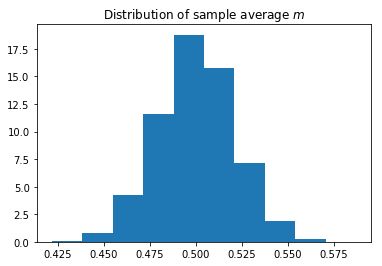

In [20]:
plt.hist(simulated_data,density=True)
plt.title('Distribution of sample average $m$')
plt.show()

This is the central limit theorem: sum (average) of uniformly distributed variable tends to a normal distribution.

As the next graph shows, the functional form is $\sigma/\sqrt{n}$.

We draw from a uniform distribution on [0,1] which has variance 1/12 [according to wikipedia](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)) and hence standard deviation $1/\sqrt{12}$.



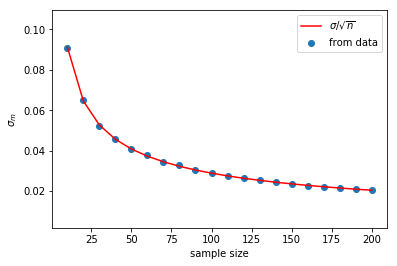

In [16]:
vector_std = []
for sample_size in np.arange(10,210,10):
    simulated_data = np.mean(tf.random.uniform([N_simulations,sample_size],0,1),axis=1)
    vector_std.append(np.std(simulated_data))

plt.scatter(np.arange(10,210,10), vector_std,label='from data')
plt.plot(np.arange(10,210,10),[1/np.sqrt(12*x) for x in np.arange(10,210,10)],c='r',label='$\sigma/\sqrt{n}$')
plt.legend()
plt.xlabel('sample size')
plt.ylabel('$\sigma_m$')
plt.show()

Above we considered the distribution of the sample mean $m$. But any parameter has a distribution; e.g. also the standard deviation of the sample $s$ has a distribution. Note that the standard deviation of the sample $s$ is **not** the same as the standard error $\sigma/\sqrt{n}$ which is the standard deviation of $m$'s distribution. Do not worry if you find the last sentence confusing in the beginning...

**Question** Plot the distribution of $s$. What is the probability that $s<0.28$?

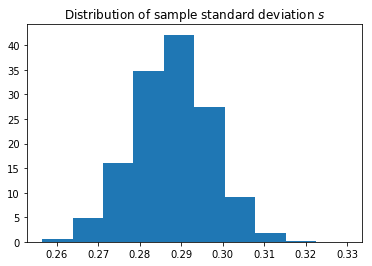

prob. that s < 0.28 equals: 0.1946


In [31]:
simulated_std = np.std(tf.random.uniform([N_simulations,sample_size],0,1),axis=1)
plt.hist(simulated_std,density=True)
plt.title('Distribution of sample standard deviation $s$')
plt.show()
print('prob. that s < 0.28 equals: {0}'.format(np.sum(simulated_std<0.28)/len(simulated_std)))

## distribution of a slope

If we run a simple OLS (ordinary least squares) linear regression, we find the constant and the slope of this line. These parameters have also distributions! We can plot these distributions as well.

We first generate the data with which we want to estimate a regression line.

**Question** Explain the code below.

In [2]:
N_simulations = 10000
sample_size = 20
slope = 0.5
constant = 1.0
noise = 0.1
simulated_x = tf.random.normal([N_simulations,sample_size])
simulated_y = constant + slope * simulated_x + noise*tf.random.normal([N_simulations,sample_size])

We create a vector `constants` and a vector `slopes`. For each of our simulations we add the resulting constant and slope to their resp. vectors.

Note that the method `.numpy()` turns the tensorflow tensors into numpy arrays which are easier to work with.

In [3]:
constants = []
slopes = []

for i in range(N_simulations):
    model = sm.OLS(simulated_y[i,:].numpy(), sm.add_constant(simulated_x[i,:].numpy()))
    results = model.fit().params
    constants.append(results[0])
    slopes.append(results[1])

**Question** Plot the distribution of slopes and the distribution of constants.

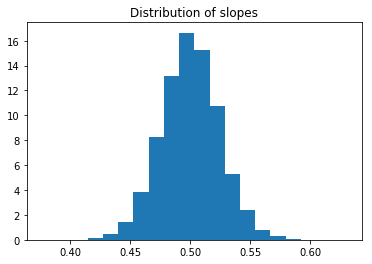

In [4]:
plt.hist(slopes,bins=20,density=True)
plt.title('Distribution of slopes')
plt.show()

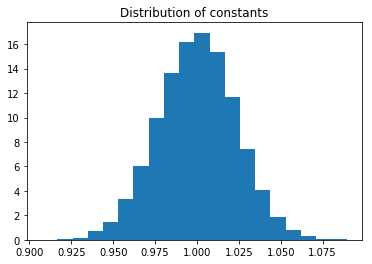

In [5]:
plt.hist(constants,bins=20,density=True)
plt.title('Distribution of constants')
plt.show()

Instead of plotting the slopes and constants separately, we can plot the lines that are induced by these distributions of the constant and the slope.

**Quenstion** Plot in $(x,y)$ space, the distribution of lines that follow from these distributions of slopes and constants.

**Question** For which values of $x$ is the uncertainty about $y$ the biggest?

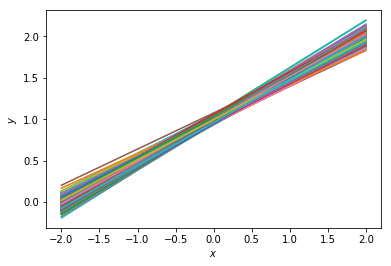

In [6]:
for i in range(1000):
  plt.plot([-2,2],[constants[i]+slopes[i]*(-2),constants[i]+slopes[i]*(2)])
  
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

# Bootstrapping

Sometimes we do not know what the underlying model is that generated the data. We only have the sample that we observed.  How do we proceed in this case if we want to test properties of the data? Here we can use bootstrapping.



Suppose that we have two populations (e.g. men vs women; or in the test of a new drug: patients that got the treatment and patients that received the placebo). Denote these two samples by $A$ and $B$. 



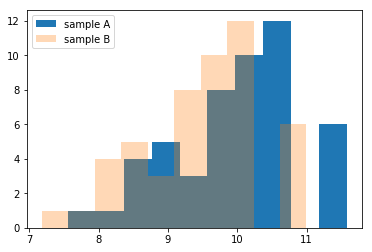

In [7]:
sample_size = 50
delta = 0.95
A = 10+tf.random.normal([sample_size])
B = A*delta
plt.hist(A,label='sample A')
plt.hist(B,alpha=0.3,label='sample B')
plt.legend()

**Question** Show that the average of $A$ is higher than the average of $B$.


In [8]:
observed_difference = np.mean(A)-np.mean(B)
print(observed_difference)

0.4978161


But is this difference in means a significant effect (forget for a second that you saw the code generating the data)?

In your statistics class you have seen a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to figure out whether this difference is significant or not. But we are going to use simulations to establish this.

The null hypothesis that we want to test is: samples $A$ and $B$ are drawn from the same distribution.

If this is true, than we can simply combine the $A$ and $B$ observations, reshuffle them and calculate the difference. We do this 10,000 times and get a distribution of the difference.

In [9]:
AB = tf.concat([A,B],axis=0).numpy()

**Question** Draw samples of 50 $A$ and 50 $B$ observations out of $AB$. Calculate the difference of the means for these two samples. Then repeat this 10000 times.

[hint: start by creating an empty list `differences`, this list will be filled with 10000 elements]

In [10]:
differences = []

for i in range(10000):
    np.random.shuffle(AB)
    differences.append(np.mean(AB[:sample_size])-np.mean(AB[sample_size:]))
                             
                      

**Question** Plot the histogram of the differences.

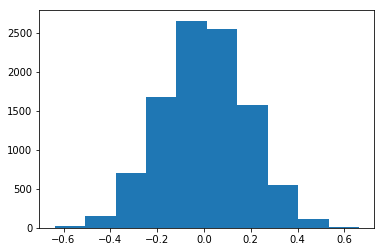

In [11]:
plt.hist(differences)
plt.show()

**Question** Calculate the fraction of the 10000 differences where this difference exceeds `observed_difference`. Is the observed difference significant?

In [12]:
sum(differences>observed_difference)/len(differences)

0.0026

**Exercise** In terms of the steps that you just programmed, formulate what a significant difference means.

Given the null hypothesis that $A$ and $B$ are drawn from the same distribution, how likely am I to observe a difference of `observed_difference` or larger.

# Doing your own OLS

There exist many packages that can do OLS for you. But it is illustrative, to program your own OLS estimator, because then you can see what it does.

We start really simple and then add some things to the estimator. This method of programming our own estimator we will use below again for estimators that you may not know yet.

For OLS, we could just substitute the solution using matrix algebra: $\beta = (x^Tx)^{-1}x^Ty$. But we want to use the optimization problem itself so that we can add things to it later on.

First, we are going to generate our own data.

Then we define a loss function (mean squared error) and minimize the loss by choosing a constant (`w[0]`) and slopes (`w[1],w[2]`).

In [5]:
sample_size = 500
slope1 = -3.0
constant = 1.0
x1 = tf.random.normal([sample_size])
x2 = tf.random.normal([sample_size])
y = slope1*x1+constant+3*tf.random.normal([sample_size])

**Question** Define a function `loss` which takes as its argument the vector $w$. The first element of $w$ is the constant, the second element is the slope of our regression w.r.t. `x1`, the third element the slope w.r.t. `x2`. 

The function `loss` returns 

$$
\frac{1}{n} \sum_{i=1}^n (w_0+w_1 x_{1i} + w_2 x_{2i} - y_i)^2
$$

where $n$ denotes the sample size.

**Question** Minimize the loss function. What values do you find for $w_0,w_1,w_2$?

In [6]:
def loss(w):
    return np.sum((w[0]+w[1]*x1+w[2]*x2-y)**2)/len(y)

optimize.fmin(loss, [0,0,0])

Optimization terminated successfully.
         Current function value: 9.116178
         Iterations: 128
         Function evaluations: 249


array([ 0.97302773, -2.86659381,  0.06669922])

## What are ridge and lasso regressions?

In machine learning, the focus is not so much on significance of estimated parameters (which we usually worry about) but on "overfitting". Overfitting is the problem where you seem to find a pattern in the data that is actually not there. It is related to the 5% significance that we worry about.

![significant](https://imgs.xkcd.com/comics/significant.png)

In case you need [an explanation](https://www.explainxkcd.com/wiki/index.php/882:_Significant).

We will look more formally at overfitting below. The simple idea of ridge and lasso regressions is the following. We do not want the coefficients to be different from zero when, in fact, there is no relationship between the $x$ variable and $y$. This is sometimes referred to as "we do not want the model to become too excited".

To avoid the model becoming too excited, we introduce a "penalty" on coefficients that are different from zero. The difference between ridge and lasso is the penalty function that is used.

With ridge the penalty function is $\sum_{i=1}^p w_i^2$ and with lasso it is $\sum_{i=1}^p |w_i|$. The penalty function is multiplied by "hyperparameter" $\lambda>0$ and added to the loss function that we used below.

Note that this procedure only makes sense if the variables are normalized. The $x$ variables are generally standardized (mean 0, standard deviation equal to 1; as they are in our case). The $y$ variable is centered: mean 0.



**Question** Create a variable `y_centered` which has mean 0.

In [7]:
y_centered = y - np.mean(y)

np.mean(y_centered)

-3.8146972e-08

**Question** Define a function `loss_ridge` with parameters `w` (vector of coefficients) and $\lambda$. 

What coefficiens do you find with $\lambda =1$?

In [8]:
def loss_ridge(w,λ):
    return np.sum((w[0]+w[1]*x1+w[2]*x2-y_centered)**2)/len(y_centered)+λ*(w[0]**2+w[1]**2+w[2]**2)

optimize.fmin(lambda w: loss_ridge(w,1), [0,0,0])

## note that coefficients are different from above because we rescaled y

Optimization terminated successfully.
         Current function value: 13.195548
         Iterations: 143
         Function evaluations: 267


array([ 0.00801572, -1.42211992,  0.03528838])

**Question** Define a function `loss_lasso` with parameters `w` (vector of coefficients) and $\lambda$. 

What coefficiens do you find with $\lambda =1$?

In [9]:
def loss_lasso(w,λ):
    return np.sum((w[0]+w[1]*x1+w[2]*x2-y_centered)**2)/len(y)+λ*(np.abs(w[0])+np.abs(w[1])+np.abs(w[2]))

optimize.fmin(lambda w: loss_lasso(w,1), [0,0,0])

## this works very well: constant = 0 because both x and y variables are rescaled to 0; also w[2] = 0 in this case

Optimization terminated successfully.
         Current function value: 11.734688
         Iterations: 209
         Function evaluations: 378


array([-2.96305870e-07, -2.35877148e+00,  4.41634832e-07])

# Causality

As you know, multiple regression is about correlations, not about causality. However, in economics we do want to know causal effects as well, e.g. when we do policy analysis. If you want to advice the government to do policy $X$ because it will increase $Y$, you need to be sure that there is a causal effect between $X$ and $Y$.

Hence, often people try to interpret the outcomes of a regression as causal relationships. When doing this, there are a number of mistakes that you can make. Here we are going to look at three of these mistakes:

* the fork
* the pipe
* the collider

Each of these three mistakes will be illustrated by a DAG ("a figure with variable names and arrows between them").


## The fork

This is the situation where there is no relation between the variables $X$ and $Y$. However, both are influenced by a third variable $Z$. 



![fork](./Fork.png)


This is the situation you probably know best. There is a missing variable that is important in the relation between $X$ and $Y$. Running a regression with only $Y$ and $X$ leads to a bias in the coefficient of $X$. In the first case we consider this is extreme in the sense that the effect of $X$ on $Y$ is zero (there is no such effect) and yet you find a significant coefficient.

Doing this regression from $X$ on $Y$ seems to suggest a causal effect of $X$ on $Y$. This could misleadingly convince people that a policy that affects $X$ directly will also affect $Y$.

However, using both $X$ and $Z$ as explanatory variables in the regression will show that there is no significant effect from $X$ on $Y$ *controlling for* $Z$.

Hence, with a fork it is important to think about possible variables $Z$ and include them in your regression.

**Question** Generate data for the variables $X,Y,Z$ such that there is a fork

**Question** Put this data in a pandas dataframe.

With the dataframe, it is easy to run the regressions.

In [10]:
sample_size = 100
slope_x = 1
constant_x = 2
slope_y = -1
constant_y = 0
z = tf.random.normal([sample_size])
x = slope_x * z + constant_x + 0.01* tf.random.normal([sample_size])
y = slope_y * z + constant_y + 0.01* tf.random.normal([sample_size])

df_fork = pd.DataFrame({'x':x, 'y':y, 'z':z})
df_fork.head()

,x,y,z
0,1.305174,0.705205,-0.695902
1,2.379026,-0.379963,0.379394
2,2.270561,-0.280797,0.279328
3,2.339656,-0.328764,0.341544
4,1.273894,0.713444,-0.722814


Now we use [statsmodels](https://www.statsmodels.org/stable/index.html) to run the regression from `x` on `y`.

Note that we just use `statsmodels` here without giving you a full explanation of its syntax. Although the commands are intuitive enough, you may want to check the [statsmodels website](https://www.statsmodels.org/stable/index.html) to understand things. Do not read everything on this website (that would be too time consuming), just browse through it and find the things that you need. 

This is good practice for later when new packages are developed and you want to quickly start using a new package. A combination of browsing through the documentation and using some "trial and error" allows you to quickly learn a package and see whether it is useful for you.

As you can see there is a negative correlation between `x` and `y` and the coefficient is "highly" significant. However, we generated the data ourselves (above) and we know that there is no direct effect from $x$ on $y$.

In [11]:
results_fork_incorrect = smf.ols('y ~ x', data=df_fork).fit()
results_fork_incorrect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.024e+05
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          1.31e-183
Time:                        10:54:35   Log-Likelihood:                 281.82
No. Observations:                 100   AIC:                            -559.6
Df Residuals:                      98   BIC:                            -554.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9986      0.003    597.483      0.000       1.992       2.005
x             -0.9996      0.001   -708.829      0.000      -1.002      -0.997
==============================================================================
Omnibus:                        1.229   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                0.718
Skew:                           0.064   Prob(JB):                        0.698
Kurtosis:                       3.395   Cond. No.                         6.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question** Run the same regression but now with both `x` and `z` as explanatory variables. What happens to the coefficient of `x`?

In [12]:
results_fork_correct = smf.ols('y ~ x + z', data=df_fork).fit()
results_fork_correct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.588e+05
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          1.47e-193
Time:                        10:58:42   Log-Likelihood:                 312.45
No. Observations:                 100   AIC:                            -618.9
Df Residuals:                      97   BIC:                            -611.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1961      0.242     -0.809      0.420      -0.677       0.285
x              0.0978      0.121      0.807      0.422      -0.143       0.338
z             -1.0978      0.121     -9.053      0.000      -1.338      -0.857
==============================================================================
Omnibus:                        4.458   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                3.880
Skew:                          -0.368   Prob(JB):                        0.144
Kurtosis:                       3.624   Cond. No.                         715.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Above we assumed that the effect of `x` on `y` is zero. Now we consider a generalized version.

**Exercise** Assume that the direct effect of `x` on `y` is linear with slope equal to 0.5 (not 0.0 as above). The other effects are the same as above. Generate the data and create a dataframe `df_fork_2`.

In [13]:
sample_size = 100
slope_x = 1
constant_x = 2
slope_y = -1
constant_y = 0
slope_xy = 0.5
z = tf.random.normal([sample_size])
x = slope_x * z + constant_x + 0.01* tf.random.normal([sample_size])
y = slope_y * z + slope_xy * x + constant_y + 0.01* tf.random.normal([sample_size])

df_fork_2 = pd.DataFrame({'x':x, 'y':y, 'z':z})
df_fork_2.head()

,x,y,z
0,1.598706,1.218101,-0.405665
1,2.151314,0.912455,0.151257
2,1.759853,1.121293,-0.251362
3,2.348002,0.828760,0.350880
4,1.333715,1.334247,-0.670185


**Exercise** Run the same regressions that we did above using `statsmodels`. Discuss the coefficients that you find.

In [14]:
results_fork_2_incorrect = smf.ols('y ~ x', data=df_fork_2).fit()
results_fork_2_incorrect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.245e+05
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          6.31e-154
Time:                        10:59:30   Log-Likelihood:                 288.91
No. Observations:                 100   AIC:                            -573.8
Df Residuals:                      98   BIC:                            -568.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0056      0.003    634.539      0.000       1.999       2.012
x             -0.5026      0.001   -352.805      0.000      -0.505      -0.500
==============================================================================
Omnibus:                        1.434   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                1.181
Skew:                           0.030   Prob(JB):                        0.554
Kurtosis:                       2.471   Cond. No.                         6.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
results_fork_2_correct = smf.ols('y ~ x + z', data=df_fork_2).fit()
results_fork_2_correct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.322e+05
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          2.32e-167
Time:                        10:59:42   Log-Likelihood:                 327.09
No. Observations:                 100   AIC:                            -648.2
Df Residuals:                      97   BIC:                            -640.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0449      0.195     -0.231      0.818      -0.431       0.341
x              0.5222      0.097      5.372      0.000       0.329       0.715
z             -1.0225      0.097    -10.542      0.000      -1.215      -0.830
==============================================================================
Omnibus:                        0.317   Durbin-Watson:                   2.207
Prob(Omnibus):                  0.854   Jarque-Bera (JB):                0.096
Skew:                           0.065   Prob(JB):                        0.953
Kurtosis:                       3.077   Cond. No.                         620.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The first regression suggests that `x` has a negative effect on `y`. However, we know that this effect is positive and equal to 0.5 (we generated the data ourselves).

The second regression correctly identifies the direct effect of `x` on `y`.

## The pipe

We are interested in the causal effect of $X$ on $Y$. In reality this effect is mediated by $Z$.

If we condition on $Z$, the regression suggests that there is no causal impact of $X$ on $Y$. It looks as if we just "solved a fork". From the data alone we do not know whether there is a fork or pipe. We need a model to separate the two situations.

![pipe](./Pipe.png)

Let us first look at a data generating process that leads to a pipe. Then we give an economic story of how a pipe can arise.

**Question** Copy/paste the code from the fork example above. Adjust the equations for `x,y,z` such that we have a pipe and not a fork. That is, make sure that `x` affects `z` which then affects `y`. Then create a dataframe `df_pipe`.


In [19]:
sample_size = 100
slope_x = 1
constant_x = 2
slope_z = -1
constant_z = 0
x = tf.random.normal([sample_size])
z = slope_x * x + constant_x + 0.01* tf.random.normal([sample_size])
y = slope_z * z + constant_z + 0.01* tf.random.normal([sample_size])

df_pipe = pd.DataFrame({'x':x, 'y':y, 'z':z})
df_pipe.head()

,x,y,z
0,0.231079,-2.237246,2.241160
1,1.220882,-3.210805,3.211702
2,0.714405,-2.709589,2.697337
3,-0.864044,-1.127718,1.123981
4,0.761011,-2.735149,2.740401


**Question** Run the regression from `x` on `y` directly and the regression where, in addition to `x`, we also control from `z`. Note that the `incorrect` regression has both `x` and `z` this time.

In [20]:
results_pipe_incorrect = smf.ols('y ~ x + z', data=df_pipe).fit()
results_pipe_incorrect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.169e+05
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          8.54e-200
Time:                        11:04:10   Log-Likelihood:                 325.39
No. Observations:                 100   AIC:                            -644.8
Df Residuals:                      97   BIC:                            -637.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0173      0.204     -0.085      0.932      -0.421       0.387
x             -0.0099      0.102     -0.097      0.923      -0.212       0.192
z             -0.9907      0.102     -9.733      0.000      -1.193      -0.789
==============================================================================
Omnibus:                        2.954   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.228   Jarque-Bera (JB):                2.094
Skew:                          -0.172   Prob(JB):                        0.351
Kurtosis:                       2.381   Cond. No.                         656.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
results_pipe_correct = smf.ols('y ~ x', data=df_pipe).fit()
results_pipe_correct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.306e+05
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          1.93e-188
Time:                        11:04:20   Log-Likelihood:                 291.32
No. Observations:                 100   AIC:                            -578.6
Df Residuals:                      98   BIC:                            -573.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9981      0.001  -1504.988      0.000      -2.001      -1.995
x             -0.9989      0.001   -794.090      0.000      -1.001      -0.996
==============================================================================
Omnibus:                        0.522   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.647
Skew:                           0.018   Prob(JB):                        0.724
Kurtosis:                       2.608   Cond. No.                         1.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question** Discuss the relevant coefficients that you find above.

In the first regression we would --incorrectly-- conclude that there is no (statistically significant) effect of `x` on `y`.

However, the second regression shows us that the correct effect is `slope_x * slope_z` $= -1$ from `x` on `y` (through `z`).

In economics an example could be the effect of schooling on poverty. Poverty can be reduced by increasing income but also by avoiding mistakes in expenditures (e.g. not taking out loans with absurdly high interest rates). Suppose the former mechanism is the main one. Then looking at the effect of schooling on poverty *controlling* for income would suggest that schooling has hardly an effect on poverty. However, there is a strong causal effect from schooling on poverty and it happens through income.

By controlling for income, you "control away" the real causal variable which is schooling.

## The collider

Many people have the intuition that adding a control variable to a regression (especially when it turns out to be signficant) is a good idea. However, this intuition is wrong if it is applied without thinking. The pipe above is a first example where this reasoning is incorrect. The collider is a second case.

We use here the education example by Richard McElreath to illustrate this point (see [Richard McElreath
's lecture 6](https://www.youtube.com/watch?v=l_7yIUqWBmE)). Consider the educational achievements of three generations in one family: the grandparent, the parent and the (grand)child. We are interested in the effect of the grandparent's education on the educational achievement of the grandchild. 

Let's denote the child's educational achievement by $Y$ (the variable we are interested in) and the grandparent's education $X$. We want to understand the effect of $X$ on $Y$. Clearly there is the following path: more educated grandparent leads to more educated parent ($Z$) which, in turn, leads to more educated grandchild. The thing we are interested in is whether there is a direct effect from the grandparent on the child, *controlling* for the parent's education.

![collider](./Collider.png)

We know that the parent's education has a positive effect on the child's achievement. A more educated parent will tend to stimulate their children more, can help with homework etc. In the data that we generate below, we assume that $Z = X + ...$ and $Y = Z + ...$. That is, we assume that the parent's education feeds one-to-one into the child's education. 

Is it the case that on top of this effect there is a separate grandparent effect? E.g. because the grandparent is babysitting and a more educated grandparent reads Hamlet with the 5 year old grandchild. That is fun and can boost the child's educational achievement.

Another important component of education is the neighborhood where the child grows up. We denote this variable $U$. In the code we assume that the parent and child grow up in the same neighborhood (have the same $U$ effect).  $U$ is drawn from a standard normal distribution and the effect on education is given through a multiplication by the factor `alpha`.

In addition to this, we assume that there is a random component as well which differs between parent and child.

![collider](./Collider2.png)

The code below, generates this data and a dataframe `df_collider` that stores this data.

Look carefully at the code: is there a direct effect from the grandparent to the grandchild's educational achievement?

We generate two dataframes: `df_collider` is the one that is observed and used in the analysis by the researcher. 

We will use `df_collider_2` to illustrate why one can get incorrect results from analyzing `df_collider`. The problem is that the researcher does not have access to `df_collider_2` but we can analyze `df_colldier_2` for "educational purposes" to illustrate why problems arise.

In [173]:
N_observations = 5000
alpha = 0.5
X = tf.random.normal([N_observations])
U = tf.random.normal([N_observations])
Z = X + alpha*U+0.4*tf.random.normal([N_observations])
Y = Z + alpha*U+0.4*tf.random.normal([N_observations])

df_collider = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
df_collider_2 = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z, 'U':U})
print(df_collider.head())
print(df_collider_2.head())

          X         Y         Z
0  1.028034  1.063288  0.835722
1 -0.970547 -2.506973 -1.579250
2  1.115138  1.784768  1.521147
3  0.307292 -0.201093  0.179020
4 -0.759817 -1.808398 -2.022265
          X         Y         Z         U
0  1.028034  1.063288  0.835722 -0.162450
1 -0.970547 -2.506973 -1.579250 -1.757083
2  1.115138  1.784768  1.521147  1.322398
3  0.307292 -0.201093  0.179020 -0.083186
4 -0.759817 -1.808398 -2.022265 -1.066982


**Question** Find the (direct) effect of the grandparent ($X$) on the grandchild's educational achievement ($Y$) conditional on the parent's education ($Z$).

In [174]:
results = smf.ols('Y ~ X + Z', data=df_collider).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 1.973e+04
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        19:46:45   Log-Likelihood:                -3706.0
No. Observations:                5000   AIC:                             7418.
Df Residuals:                    4997   BIC:                             7438.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0025      0.007      0.351      0.7

The effect of the grandparent's educational achievement ($X$) on the child's achievement is negative and significant. 

**Question** Where does this negative efffect come from? How is this even possible?

**Question** Find the direct effect of $X$ on $Y$. Which sign does this effect have? What is the interpretation?

In [175]:
results2 = smf.ols('Y ~ X', data=df_collider).fit()
print(results2.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     3983.
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        19:46:47   Log-Likelihood:                -7704.9
No. Observations:                5000   AIC:                         1.541e+04
Df Residuals:                    4998   BIC:                         1.543e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0286      0.016      1.788      0.0

We will come back to the negative correlation using graphs below.

The positive effect of grandparents ($X$) on grandchild education ($Y$) is via the parent's education ($Z$): better educated grandparent leads to better education parent which in turn leads to better educated grandchild.

To understand the negative effect of $X$ on $Y$, let's think about what it means to "control for parental education $Z$". 

To visualize what happens, we condition on $Z$ by focusing on a narrow band of $Z$ observations. In other words, we condition on $Z$ by focusing on a subsample where the $Z$ values are (almost) the same. We do this by creating a column `selected` in our dataframe.

In [176]:
df_collider['selected'] = np.abs(df_collider.Z)<0.05
df_collider.head()

,X,Y,Z,selected
0,1.028034,1.063288,0.835722,False
1,-0.970547,-2.506973,-1.579250,False
2,1.115138,1.784768,1.521147,False
3,0.307292,-0.201093,0.179020,False
4,-0.759817,-1.808398,-2.022265,False


**Question** Plot $X$ against $Y$ for all the data (in blue) and for the values of $Z$ where $|Z|<0.05$ (in orange).

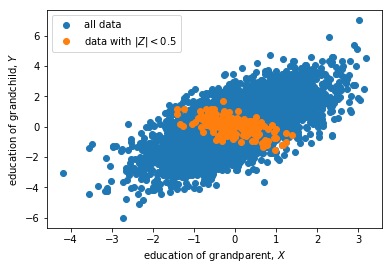

In [177]:
plt.scatter(df_collider.X,df_collider.Y,label='all data')
plt.scatter(df_collider[df_collider.selected].X,df_collider[df_collider.selected].Y, label = 'data with $|Z| < 0.5$')
plt.xlabel('education of grandparent, $X$')
plt.ylabel('education of grandchild, $Y$')
plt.legend()
plt.show()

**Question** Give the intuition why there is a negative correlation between $X$ and $Y$ with the orange dots. [hint: what do you know about orange dots with low $X$ and about orange dots with high $X$?]

If you cannot answer this question yet, consider the following interactive graph.



Consider the orange dots above. Each of these has (approx.) the same parental education $Z$. Consider an orange dot with low $X$; how can the parent still have a relatively good educational record? 

The neighborhood $U$ must have been quite good. All orange points have the same $Z$ but points with low $X$ have very good neighborhoods. Hence, the low $X$ *for given* $Z$ will lead to high $Y$. These grandchildren live in exceptionally good neighborhoods and hence have high educational attainment $Y$.

A high $X$ value, for given $Z$ implies that the neighborhood is not very good. Hence, *for given* $Z$, the achievement of the grandchild will be rather low.

This is how we get a negative correlation between $X$ and $Y$ for given $Z$. 

In this sense, the correlation is "correct"; but it may not be what you expect. And it is easy to mis-interpret this result.



To better understand what is happening here, we are going to use `df_collider_2`. In particular, in the combined figure below, we again provide a scatter plot of `X` vs `Y`. Now the color indicates the level of `Z` associated with the observation; darker colors indicate higher values of `Z`. The size of the point (circle) indicates the level of `U` (that the researcher cannot see in `df_collider`).

To better illustrate what is happening, we use an interactive plot made with [altair](https://altair-viz.github.io/).

To condition on `Z` (as we do in a multiple regression), we can drag a rectangle in the bottom histogram. That is, drag the rectangle so that you "capture" a bar in the histogram. This selection of $Z$ turns blue and you can drag the selection up and down (conditioning on different values of $Z$).

Move this selection up and down and see what happens. In particular:
* how does `Z` vary in the figure? E.g. where are the high values of `Z`? What is the interpretation of this?
* for a selection of `Z` in the bottom histogram, what is the relation between `X` and `Y`?
* for this selection, how does `U` vary in the figure? That is, for a given selection of $Z$ what is the size of the circles? What is the interpretation?


**Question** Give the intuition why there is a negative correlation between `X` and `Y` for a selection of `Z`; that is, conditional on `Z`.

**Exercise** What is the risk of saying: I have run a regression and controlled for all effects that I had variables for?

In [178]:
interval = alt.selection_interval(encodings=['y'])

fig = alt.Chart(df_collider_2).mark_point().encode(
  x='X',
  y='Y',
  color=alt.condition(interval, 'Z', alt.value('lightgreen')),
  size = 'U'
).properties(
    selection=interval

)



hist = alt.Chart(df_collider_2).mark_bar().encode(
    x='count()',
    y=alt.Y('Z',bin=True),
    color=alt.condition(interval, 'Z', alt.value('lightgrey'))
).properties(
    selection=interval

)

chart_collider = fig & hist

chart_collider.save('ChartCollider.html')

In [179]:
%%HTML

<iframe width="840" height="800" src="./ChartCollider.html" frameborder="0"></iframe>

For a given value of parent education $Z$, consider 2 different levels of grandparent education $X_l,X_h$ with $X_h > X_l$. At low grandparent education $X_l$ we can only get to the same level of parent education $Z$ if the neighborhood ($U$) was very good. The circle above is quite big.

For high $X_h$ to lead to same parent education level $Z$, the neighborhood must have been "below average": small circles in the figure above.

Since we are controlling for parental education $Z$, the effect on grandchild educational achievement is driven by neighborhood: at $X_l$, the neighborhood was good and $Y$ is high. At $X_h$, the neigborhood was not very good and $Y$ is low. Hence we get a negative association between $X$ and $Y$.

If we could observe $U$ and control for it, we find:

In [29]:
results_3 = smf.ols('Y ~ X + Z + U', data=df_collider_2).fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 2.331e+04
Date:                Thu, 11 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:48:31   Log-Likelihood:                -2472.4
No. Observations:                5000   AIC:                             4953.
Df Residuals:                    4996   BIC:                             4979.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0066      0.006     -1.173      0.2

Hence, we find no effect of $X$ on $Y$ and a positive effect of $Z$ on $Y$, which is in line with how we generated the data.

Further $U$ has a positive effect on $Y$ as well.

But if we cannot observe $U$, we cannot "solve" the collider. We either find the positive effect of $X$ on $Y$ (via parental education $Z$) or we find the counter-intuitive negative effect when we control for $Z$.

# Some background on tensors

In the past, when you worked with data, you would usually have 2-dimensional data: columns for the different variables and rows for the different observations. That is, the data is represented as a matrix.

However, "big data" is not necessarily structured in such a neat way. Data can have higher dimensions. We will start with data on images. An image has two dimensions of itself. Hence a dataset with images has 3 dimensions: one dimension for the identifier of the image and then x-y coordinates for the image itself.

If the dataset consists of movie-clips, we have an additional dimension: time.

In economics, when we look at GDP, our observation would be GDP of the UK in 2010, GDP of the UK in 2011, GDP of Belgium in 2010 etc. This can be represented as a matrix.

But now suppose we believe the development of GDP is important. Our observation would be GDP of the UK in 2010-2018. This gives 3 dimensional data. The observation is GDP in the period. 

To deal with higher dimensional data, we need "tensors". A tensor generalizes a matrix to higher dimensions.

We will now have a technical interlude to explain what tensors are and what you can do with them. We describe some functions that can be applied to tensors. To motivate these functions, we will build our first neural network. The point here is not so much to explain how neural networks work but more to show you that the functions we consider are going to be useful later on when we will try to understand neural networks more deeply.

Machine learning packages tend to have a "backbone" that implements tensors. E.g. Keras allows you to work with either [Theano](http://www.deeplearning.net/software/theano/) or [tensorflow](https://www.tensorflow.org/).

## Tensors

As mentioned, in most of the empirical analyses that you have done, an observation is a one dimensional vector. E.g. you have data on inflation, unemployment, gdp growth for country-year combinations. Then for the UK in 2000, our data  consists of the one dimensional vector `[inflation, unemployment, gdp growth]`. If you have 100 observations like this, you can represent them in a matrix. Each row is an observation and the columns will be `[coutry, year, inflation, unemployment, gdp growth]`. Hence we have a two dimensional dataset with 100 rows and 5 columns.

In big data, there are usually higher dimension observations. One of the "classic" datasets in machine learning is [the MNIST dataset.](https://en.wikipedia.org/wiki/MNIST_database) This dataset consists of handwritten numbers and their corresponding label (e.g. when the handwritten number is 5, the label for this image `5`). We will see an example shortly.

The point is that a handwritten number is a two dimensional observation. For each x-y comination, we get the grey-scale of this point/pixel. To illustrate this, consider the 5th image from the training dataset (python starts numbering at 0); we plot the handwritten image (which is 2 dimensional) and print its label.

This data is already split in a train and test set. Something we will elaborate on below.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

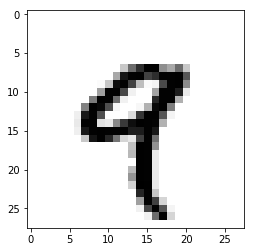

9


In [4]:
plt.imshow(train_images[4],cmap=plt.cm.binary)
plt.show()
print(train_labels[4])

If you want to "see" what the data look like, uncomment the next cell and evaluate it.

In [7]:
#train_images[4]

Indeed, the handwritten number is 9, which equals its label.

What are the dimensions for this dataset. Let's use `shape` to find out. Friendly warning, when you go into machine learning, you will be using `shape` a lot!

In [9]:
train_images.shape

(60000, 28, 28)

That is, we have 60,000 images in the train-set and each image is of the form 28 by 28 (pixels).

As an illustration, the dimensions of the first image in the dataset `train_images`.

In [10]:
train_images[0].shape

(28, 28)

## Tensors in numpy

As mentioned, well known machine learning backends are theano and tensorflow. For reasons that we do not worry about here, these are not immediately straightforward to work with (but we have used some tensorflow already above). We can play around with dimensions in "good old" numpy as well. Properties that we can use in numpy, like broadcasting, can be used in theano and tensorflow as well.

As numpy is "more direct" to work with, we will practice this with numpy.

**Remark** Although you are always encouraged to play around with code to see what happens, this is especially the case with tensors. To familiarize yourself with tensors, change the code that we use below; e.g. create a 10 dimensional vector out of the data. You can check for yourself whether the code generates what you expect it to generate. If not, and you cannot figure out what happens, ask us!

First, we create the vector `x` with 100 random numbers. 

In [18]:
x = np.random.normal(0,1,size=100)

**Question** Use `shape` to find the shape of the vector `x`.

In [12]:
x.shape

(100,)

As you can see, `x` has 100 elements in one dimension and no other dimension. Put differently, `x` is one-dimensional as a tensor.

This we can verify using `ndim`:

In [13]:
x.ndim

1

**Do not panic:** The following sentence will be a bit confusing when you first read it, but you will get used to it later. If you would plot the vector `x` it would be a *vector* in a 100-dimensional space. Hence it is a 100 dimensional vector, but a 1 dimensional tensor.

To understand this better, let's consider a two dimensional (2D) tensor. This is what we usually call a matrix:

In [14]:
x2 = x.reshape(25,4)
print(x2.ndim)
print(x2.shape)

2
(25, 4)


By evaluating `x2` we see that this indeed "looks like" a matrix. 

In terms of python, we can see the two dimensions as follows:
* each row has four elements (columns) separated by comma's (`,`) in between square brackets, like `[1,2,3,4]`; 
* then between square brackets, we have 25 of such rows; again rows separated by comma's.

In [17]:
x2

array([[ 0.43039847, -0.18971864,  0.42519277,  0.76094946],
       [-0.43028274, -2.04155479, -0.08631933,  2.11045887],
       [-1.42133004, -0.52557509, -1.18514198,  1.31744594],
       [ 2.63634025,  1.10630258,  0.93078797, -0.04308814],
       [ 0.26047991,  1.09189891,  0.93715493,  0.65121552],
       [ 0.53117809, -0.03687864,  0.14097119, -0.79780483],
       [ 0.31801858,  1.49815025, -0.68677996,  1.16897524],
       [-0.07717613,  0.37291292, -0.38493892,  0.90477142],
       [-0.5111465 , -1.42062458, -0.21835386,  0.28010054],
       [-2.14945073,  0.38696359, -0.72001128,  1.06370857],
       [-0.04407563,  0.32375656, -0.5525406 ,  0.7679692 ],
       [-1.44509335, -1.28600877, -0.48705055, -1.7431975 ],
       [-0.24177759, -0.28062367, -1.42306967,  1.87071843],
       [ 0.84926282,  1.82832301, -0.56001574, -0.12611429],
       [ 0.24126222, -0.39126638,  0.69671538, -0.94735502],
       [ 0.83171065, -0.0337962 , -0.4283511 , -0.24210252],
       [-1.35181647, -0.

Note how the `reshape` method turns the 100 elements of the 1-dimensional vector `x`into a matrix with 25 "rows" and 4 "columns". This matrix is 2-dimensional.

**Question** Create a 3-dimensional vector `x3` out of `x` with shape 4 by 5 by 5. Check the dimensions and shape of `x3`.

In [19]:
x3 = x.reshape(4,5,5)
print(x3.ndim)
print(x3.shape)

3
(4, 5, 5)


One way to think about `x3` is as four $5*5$ images. The numpy representation of this is as follows:

In [20]:
x3

array([[[-0.12446782, -0.47754069,  0.28286253,  0.4053421 ,
         -0.16802273],
        [ 2.20558296, -0.05118773,  1.39500378,  1.78488186,
          1.08235686],
        [ 0.87686522, -0.20671631,  0.35100561,  0.64903912,
          0.9957796 ],
        [ 0.16289835,  0.50182196, -1.30775613,  0.83145719,
         -0.63678251],
        [-0.11677272,  1.94690424, -0.04884202, -0.98654782,
          0.21946028]],

       [[-0.22051306,  0.6758049 , -0.6831547 ,  0.41652044,
          0.87625944],
        [ 0.13993186,  1.09146755, -0.53629067,  0.60675307,
         -1.21909651],
        [-1.44544852,  0.42683751, -1.95228316,  0.34846495,
          0.09533901],
        [-1.25140429,  1.37686909, -0.0575734 , -0.3705979 ,
         -1.50041301],
        [ 0.6209617 ,  0.3626973 , -0.34769965, -0.81597961,
         -0.78446973]],

       [[-0.76301464,  0.22877353,  0.90032074, -0.73119446,
          0.0369272 ],
        [ 0.90228752,  1.40042031, -0.70867195,  0.84391395,
          0

With `np.newaxis` we can add a dimension to a vector without adding or re-arranging data. This works as follows:

In [21]:
x4 = x3[:,:,:,np.newaxis]
print(x4.ndim)
print(x4.shape)

4
(4, 5, 5, 1)


Now if you evaluate `x4`, it looks a lot like `x3`. But if you look carefully there is an additional pair of square brackets `[]`. 

You may wonder why it is useful to add a `newaxis` to a tensor. Actually, one good reason for this is broadcasting.

## Broadcasting

Broadcasting is one of the things in python that are rather complicated to understand at first, but which is extremely useful and powerful once you "get it". Let's start with an example.

Suppose you have estimated a fixed effect model. In your data there are i = 0,1,...,9 individuals and t = 0,1,2 periods. The vector `I` consists of 10 individual fixed effects and the vector `T` has 3 time fixed effects. Hence, our prediction for indiv. `i` in time period `t` (ignoring other explanatory variables) is $y_{it}=I_i+T_t$. 

How can we calculate the vector `y`? When you first think of this, you may have ideas for a "double loop": one loop over $i$ and one over $T$. In fact no loops are necessary at all, making the code "very readable".

We will define the vectors $I$ and $T$ in such an (artificial) way that you can immediately verify whether we get the sum of the effects right.

**Question** What do the vectors $I$ and $T$ look like? Can they be added in this way?


In [29]:
I = np.arange(0,100,10)
T = np.arange(0,3)

In [30]:
print(I)
print(T)

[ 0 10 20 30 40 50 60 70 80 90]
[0 1 2]


They cannot be added in this way as they have different lengths; this generates an error.

In [31]:
I+T

ValueError: operands could not be broadcast together with shapes (10,) (3,) 

Because of the simplistic numbers that we have chosen, it is easy to see that e.g. $y_{91} = 91$ with $i=9$ and $t=1$. 

We will use the "broadcasting trick" and check whether our trick works. Then we explain broadcasting.

In [34]:
y = I[:,np.newaxis]+T[np.newaxis,:]

In [35]:
y

array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32],
       [40, 41, 42],
       [50, 51, 52],
       [60, 61, 62],
       [70, 71, 72],
       [80, 81, 82],
       [90, 91, 92]])

This seems to have worked!

To understand what happens here, evaluate `I[:,np.newaxis]` and `T[np.newaxis,:]` separately.



In [37]:
I[:,np.newaxis]

array([[ 0],
       [10],
       [20],
       [30],
       [40],
       [50],
       [60],
       [70],
       [80],
       [90]])

In [48]:
T[np.newaxis,:]

array([[ 0, 10, 20]])

In words, `I` is a column vector" only one column and 10 rows and `T` is a row vector: 3 columns and only 1 row.

**Question** Check the shape of these vectors to see whether this description is correct.

In [38]:
print(I.shape)
print(T.shape)

(10,)
(3,)


Adding these two vectors together using broadcasting leads to an element by element addition of the vectors. 

In fact, we have used a simple form of broadcasting before in our python classes. See, for instance,

In [39]:
T + 1

array([1, 2, 3])

This is simple since 1 has no dimension.

Read [this article on broadcasting](https://docs.scipy.org/doc/numpy/user/theory.broadcasting.html#array-broadcasting-in-numpy) and [this one](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) to learn more about it.

To see whether two tensors can be added, we start looking at the end. In particular, as the latter article states, when "operating on two arrays, NumPy compares their shapes element-wise. It starts with the trailing dimensions, and works its way forward. Two dimensions are compatible when

1. they are equal, or
2. one of them is 1"

Let's consider a number of examples.


In [40]:
x = np.random.normal(0,1,size=100)
y = np.random.normal(0,1,size=100)

**Question** Which of the following can be added? First, think about it. Then check by running the code in a cell.

* `x+y`
* `x.reshape(10,10)+y`
* `x.reshape(10,10)+y.reshape(4,5,5)`
* `x.reshape(10,10)+y.reshape(10,10,1)`
* `x.reshape(10,10)+y.reshape(10,10,1)`
* `x.reshape(10,10)+y.reshape(5,10,2)`
* `x.reshape(10,10)+y.reshape(100,1,1)`

In [49]:
x.reshape(10,10)+y.reshape(10,10,1)

array([[[ 4.73849806e-01, -2.70211597e+00, -3.03361881e+00,
         -1.29967777e+00,  1.45875009e+00, -1.17433360e+00,
         -2.59558237e-01,  2.63875805e-01, -4.26498603e-01,
         -1.38886521e+00],
        [ 2.14702111e-01,  1.22070447e+00, -1.07671121e+00,
          3.19952361e+00,  7.39180294e-02,  1.15149868e-01,
          5.77374634e-01, -1.14050699e+00,  5.31443163e-01,
          7.56551911e-02],
        [ 7.13978678e-01,  5.76403286e-02, -1.36485881e+00,
         -3.37734538e-01,  2.88862296e-01, -9.19758641e-01,
          1.63696405e-01,  8.75558284e-01, -2.35729181e-01,
          1.88062004e+00],
        [-1.62998645e+00, -2.40052046e+00, -1.13986685e+00,
         -2.56358684e+00, -1.83907500e+00, -1.20096748e+00,
         -2.53201814e+00, -3.63129606e+00, -2.11009733e+00,
         -1.56561849e+00],
        [-1.80518657e+00, -1.49018511e+00, -1.73984969e+00,
         -6.79843679e-01, -8.66091028e-01, -1.77594849e+00,
         -1.51321266e+00,  4.72164112e-01, -1.251258

## Slicing and (fancy) indexing

Sometimes you want to have a subset from your data; e.g. to divide your data in a train and test set.

In python, subsets are created using slicing.

To see how slicing works, let's create an "easy" matrix to work with.

**Question** create a matrix `x` of the form:

```
array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
       [ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20],
       [ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30],
       [ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40],
       [ 41,  42,  43,  44,  45,  46,  47,  48,  49,  50],
       [ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70],
       [ 71,  72,  73,  74,  75,  76,  77,  78,  79,  80],
       [ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90],
       [ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100]])
```


In [54]:
x = np.arange(1,101).reshape(10,10)

We start with single elements, to make sure we understand indexing of an array.

**Question** Use indexing on `x` to get:
* `55`
* `1`
* `100` (and do this in two different ways)

In [61]:
print(x[5,4])
print(x[0,0])
print(x[9,9])
print(x[-1,-1])

55
1
100
100


Now we want a series of elements. For this we use slicing notation. To get the first row, we do

In [63]:
x[0,:]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

That is, we take the first element in the first dimension (a row) and then all elements (`:`) in the other dimension (columns).

**Question** Give the fifth column.

In [64]:
x[:,4]

array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])

In [ ]:
To get the second half of the first row:

In [76]:
x[0,5:]

array([ 6,  7,  8,  9, 10])

To get every other element from this part of the row:

In [77]:
x[0,5::2]

array([ 6,  8, 10])

To get the top left 2*2 matrix:

In [79]:
x[:2,:2]

array([[ 1,  2],
       [11, 12]])

Finally, to get the diagonal:

In [80]:
x[range(10),range(10)]

array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])

**Question** What does the following slicing operation do?

In [82]:
x[1::2,1::2]

array([[ 12,  14,  16,  18,  20],
       [ 32,  34,  36,  38,  40],
       [ 52,  54,  56,  58,  60],
       [ 72,  74,  76,  78,  80],
       [ 92,  94,  96,  98, 100]])

It starts from the second row and second column (index 1) and takes every other element (`2`).

**Question** Use slicing to get the following:
* `[81, 82, 83, 84, 85, 86, 87, 88, 89, 90]`
* `[ 3, 13, 23, 33, 43, 53, 63, 73, 83, 93]`
*
```
[[56 57]
 [66 67]]
```
* 
```
[[23 25 27]
 [43 45 47]
 [63 65 67]]
```


* the first row in reverse order: `[10  9  8  7  6  5  4  3  2  1]`



In [96]:
print(x[8,:])
print(x[:,2])
print(x[5:7,5:7])
print(x[2:8:2,2:8:2])
print(x[0,::-1])

[81 82 83 84 85 86 87 88 89 90]
[ 3 13 23 33 43 53 63 73 83 93]
[[56 57]
 [66 67]]
[[23 25 27]
 [43 45 47]
 [63 65 67]]
[10  9  8  7  6  5  4  3  2  1]


We can also use a condition to select elements from a tensor. That is, we create a boolean mask (with `True` and `False`) and then only the `True` elements are selected. This is called fancy indexing.

Let's start simple.


In [98]:
test = np.arange(5)
mask = test > 2
test[mask]

array([3, 4])

In [99]:
mask

array([False, False, False,  True,  True])

There is no need to define the `mask` separetely, the following works as well:

In [100]:
test[test>2]

array([3, 4])

**Question** Select from `x` the values between 50 and 60.

[hint: use `&` as `and`]

In [101]:
x[(x>50)&(x<60)]

array([51, 52, 53, 54, 55, 56, 57, 58, 59])

When two tensors $x,y$ have the same dimensions, we can select from $x$ based on a condition for $y$.

To illustrate this, we create three vectors `x,y,z`.

In [105]:
x = np.random.normal(size=10)
y = np.random.normal(size=10)
z = np.random.normal(size=10)

**Question** Plot `x` against `y` and color points with $z>0.5$ orange.

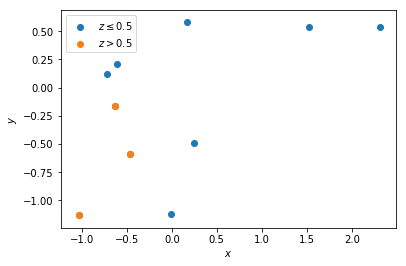

In [112]:
mask = z > 0.5
plt.scatter(x,y,label='$z \leq 0.5$')
plt.scatter(x[mask],y[mask],label='$z>0.5$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

## First neural network

As an application of our tensors, let's consider a neural network. Let's not worry about the syntax of the model. Just note that as input we use the shape of a figure: 28 by 28 pixels. Hence, the input ("x" variable) is here a 2 dimensional tensor.

Below we will come back to `relu` and `softmax`.

More information about the optimizer `adam` can be found [here.](https://medium.com/@nishantnikhil/adam-optimizer-notes-ddac4fd7218)

In [133]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



We estimate ('fit') the model on the train set.

In [134]:
model.fit(train_images, train_labels, epochs=5)


Epoch 1/5
60000/60000 [==============================] - 3s 46us/sample - loss: 2.3269 - accuracy: 0.8587
Epoch 2/5
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3594 - accuracy: 0.9104
Epoch 3/5
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2951 - accuracy: 0.9257
Epoch 4/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.2569 - accuracy: 0.9352
Epoch 5/5
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2316 - accuracy: 0.9415


Then we check the acciracy of the model on the test set:

In [135]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('\nTest accuracy:', test_acc)


10000/10000 [==============================] - 0s 26us/sample - loss: 0.2921 - accuracy: 0.9222

Test accuracy: 0.9222


We can generate predictions for the test set and consider explicitly the prediction for the first image (index 0). This prediction gives the probability for each possible label 0-9. The probability on label "7" equals 99%. Hence, if we need to make a (point) prediction, we predict that the first image is a "7".

In [136]:
predictions = model.predict(test_images)
predictions[0]

array([0.0000000e+00, 3.6320824e-08, 7.6821953e-09, 2.3646876e-10,
       4.1662474e-18, 2.4639377e-10, 3.3964793e-24, 1.0000000e+00,
       1.1814830e-16, 2.4861389e-14], dtype=float32)

In [137]:
np.argmax(predictions[0])


7

The prediction is "7" and indeed the label of this image is "7" as well:

In [138]:
test_labels[0]


7

We can plot the first image and indeed it looks like a 7.

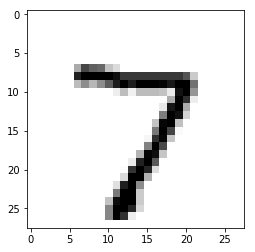

In [139]:
plt.imshow(test_images[0],cmap=plt.cm.binary)
plt.show()

## Functions

What is `relu` and `softmax`?


The relu (rectified linear unit) function is of the form $\max(0,x)$. Soft-max is of the form

$$
\frac{e^{x_i}}{\sum_i e^{x_i}}
$$

We can plot both functions:

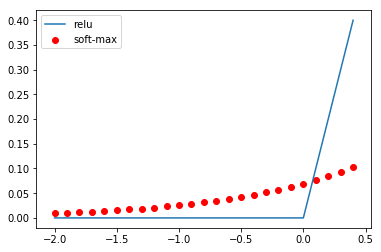

In [140]:
range_x = np.arange(-2,0.5,0.1)
plt.plot(range_x,np.maximum(range_x,0),label='relu')
plt.scatter(range_x,np.exp(range_x)/np.sum(np.exp(range_x)),label='soft-max',color='r')
plt.legend()



Below we will come back to neural networks in detail.

# Overfitting and underfitting


Adding more explanatory variables to a regression cannot make the fit worse. This is easy to see: if it would become worse, you would set the coefficient on the added variables to 0. That would give the same fit as before.

A bit more formally, OLS solves the following minimization problem:
$$
\min_{\beta} \sum_{i=1}^N (y_i - \hat y_i(\beta))^2
$$
where the prediction $\hat y_i$ is a function of the parameter values $\beta$ that we choose. Having a larger vector $\beta$ (more explanatory variables) cannot increase this objective function

There are two problems when one does machine learning (or any other form of statistical analysis):
* underfitting and
* overfitting.

Underfitting is the situation where a variable is important to explain $y$ but you do not include it in the regression. As most people have a tendency to include as many variables as possible, this is usually not a problem. Unless, of course, you do not have data on an important variable, but then you cannot really solve this problem.

Overfitting is the situation where you include variables in your regression that are actually not relevant. The reason why this happens is that including these variables improves the fit of the model (see above and an example below). But the problem is that you are picking up correlations that are particular to the sample; not a (general) feature of the data generating process.

There are a number of ways to deal with this. One is the lasso and ridge regressions we discussed above. Another is the use of an information criterion like [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and its generalizations. The idea of AIC is to include a penalty in the expression for the fit for the number of parameters.

But if you have lots of data (which is the case if you work with "big data"), there is a simple way to deal with this: split your data into a train and test set. You estimate the model with the train set (you "train the model"). And then check the fit with the test set. If you pick up particular correlations in the train set, your predictions in the test set become worse.

Let's first look at an example. We generate data with a quadratic relation between $x$ and $y$. Then we generate more variables: $x^3, x^4, ..., x^9$. 

Including all these extra variables in training the model, improves the fit. The sum of squared residuals decreases with the number of explanatory variables in the train set. However, this is not true in the test set.

First, we generate the data:



In [207]:
N_observations = 30
train_size = 15
x = tf.random.normal([N_observations],seed=26)
y = x+2*x**2+2*tf.random.normal([N_observations],seed=50)
df = pd.DataFrame({'y':y,'x':x})
df['constant'] = 1
df['x2'] = df.x**2
df['x3'] = df.x**3
df['x4'] = df.x**4
df['x5'] = df.x**5
df['x6'] = df.x**6
df['x7'] = df.x**7
df['x8'] = df.x**8
df['x9'] = df.x**9
df_train = df[:train_size]
df_test = df[train_size:]

We split the dataset (dataframe) into a train and test set (using slicing).

Then we estimate a series of regressions, starting with $y$ explained by a constant and variable $x$ and adding a term $x^n$ for $n=2,...,9$. Hence, we estimate 9 regressions.

In [208]:
regression = 'y ~ x'
vector_results = [smf.ols(regression, data=df_train).fit()]
for column in df.columns[3:]:
    regression = regression+' + '+column
    vector_results.append(smf.ols(regression, data=df_train).fit())

When we plot sum of squared residuals, we see --as claimed above-- that the fit improves with each variable $x^n$ that we add to the regression. Hence, this gives the impression that adding all 9 terms is a good idea.

However, we generated the data ourselves and we know that there are no terms $x^9$ in the data generating process.

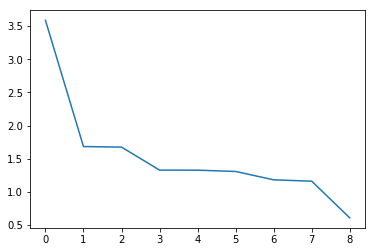

In [231]:
plt.plot([tf.keras.losses.mse(df_train['y'],model.predict(df_train)).numpy() for model in vector_results])

Next we use the 9 models that we estimated above to predict the outcomes in the test set. For each model we plot the sum of squared residuals in the test set.

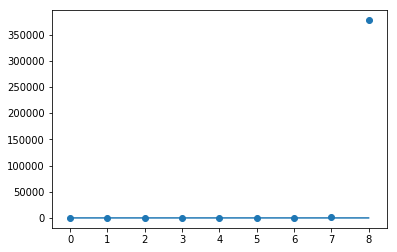

In [229]:
    
plt.plot([np.sum((df_train['y']-model.predict(df_train))**2)/len(df_train['y']) for model in vector_results])
plt.scatter(range(9),[tf.keras.losses.mse(df_test['y'],model.predict(df_test)).numpy() for model in vector_results])

The fit of the final model is so bad, that we cannot see the pattern in the 8 other models. Hence, for the next plot we delete the 9th model.

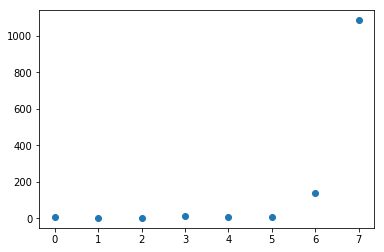

In [228]:
plt.scatter(range(8),[tf.keras.losses.mse(df_test['y'],model.predict(df_test)).numpy() for model in vector_results[:8]])

As you can see, the fit does not monotonically improve with the size of the model. This due to the model picking up patterns that are present in the train sample but which do not generalize to the test sample.

To understand why this happens, let's plot the train and test data points together with the prediction of the final model.

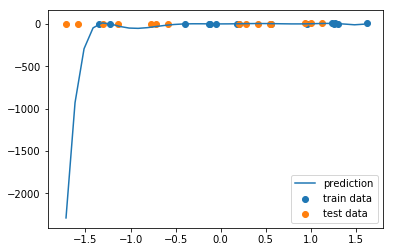

In [212]:
range_x = np.arange(min(x),max(x),0.1)
df_plot = pd.DataFrame({'x':range_x})
df_plot['constant'] = 1
df_plot['x2'] = df_plot.x**2
df_plot['x3'] = df_plot.x**3
df_plot['x4'] = df_plot.x**4
df_plot['x5'] = df_plot.x**5
df_plot['x6'] = df_plot.x**6
df_plot['x7'] = df_plot.x**7
df_plot['x8'] = df_plot.x**8
df_plot['x9'] = df_plot.x**9
plt.scatter(df_train['x'],df_train['y'],label='train data')
plt.plot(range_x,vector_results[-1].predict(df_plot),label='prediction')
plt.scatter(df_test['x'],df_test['y'],label='test data')
plt.legend()

Since the prediction is "way off" for low values of $x$, let's zoom in on the prediction (use a more narrow `range_x`). 

Now it becomes clearer what the estimation in the train set is trying to achieve. But it is also clear that this does not generalize to the test data (orange points).

This is exactly what overfitting does.

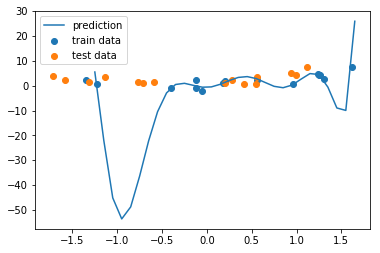

In [217]:
range_x = np.arange(-1.25,1.7,0.1)
df_plot = pd.DataFrame({'x':range_x})
df_plot['constant'] = 1
df_plot['x2'] = df_plot.x**2
df_plot['x3'] = df_plot.x**3
df_plot['x4'] = df_plot.x**4
df_plot['x5'] = df_plot.x**5
df_plot['x6'] = df_plot.x**6
df_plot['x7'] = df_plot.x**7
df_plot['x8'] = df_plot.x**8
df_plot['x9'] = df_plot.x**9
plt.scatter(df_train['x'],df_train['y'],label='train data')
plt.plot(range_x,vector_results[-1].predict(df_plot),label='prediction')
plt.scatter(df_test['x'],df_test['y'],label='test data')
plt.legend()

**Question** Make the plots of data and prediction for models 5, 6 and 7. Adjust `range_x` such that you can see "what is going on".

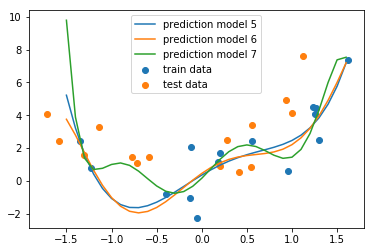

In [220]:
range_x = np.arange(-1.5,1.7,0.1)
df_plot = pd.DataFrame({'x':range_x})
df_plot['constant'] = 1
df_plot['x2'] = df_plot.x**2
df_plot['x3'] = df_plot.x**3
df_plot['x4'] = df_plot.x**4
df_plot['x5'] = df_plot.x**5
df_plot['x6'] = df_plot.x**6
df_plot['x7'] = df_plot.x**7
df_plot['x8'] = df_plot.x**8
df_plot['x9'] = df_plot.x**9
plt.scatter(df_train['x'],df_train['y'],label='train data')
plt.plot(range_x,vector_results[-5].predict(df_plot),label='prediction model 5')
plt.plot(range_x,vector_results[-4].predict(df_plot),label='prediction model 6')
plt.plot(range_x,vector_results[-3].predict(df_plot),label='prediction model 7')
plt.scatter(df_test['x'],df_test['y'],label='test data')
plt.legend()

Using a train and test set helps to alleviate over- and underfitting problems. But the test set should only be used once. If you repeatedly use the train and test set to see which model is best, you make the same mistake as above but "on a higher level": you may find patterns in the train set that generalize only to the test set but not to the data generating process.

So how can you select your best model if you cannot use the test set for this? The answer is: we split the dataset in three parts: a train, validate and test set. That is, we use the train set to fit the model. Then we repeatedly use the validation set to see what the best model is. Then our final model, we test only once on the test set.

This splitting of the data into three different (sub)sets is the royal road to testing the predictions of your model. Below --for ease of exposition-- we will not always to this. We tend to illustrate problems using a train and test set. We are not trying to optimize a given model by finetuning each parameter. For such finetuning, three subsets of data are recommended.

Suppose you have a train and test set and your trained model does really well on the test set. How do you know that this is not by chance, e.g. due to the way you have split the data into the train and test set? One way to check is to do the analyses for a number of ways in which you can split the data into train and test sets and for each these cases consider the loss on the test set. If this is rather constant across the different ways in which you split the data, you do not need to worry. If this vary wildly between data partitions, something "odd" may be going on. 

One way of generating these different data partititions is k-fold cross-validation. See the [wikipedia page on cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for details.

# Neural network

To get a first sense of how a neural network works, we look at two simple python programs that implement these algorithms. For this, we use the website from the book [machine learning: an algorithmic perspective](http://homepages.ecs.vuw.ac.nz/~marslast/MLbook.html).

Below you find the code for the files [pcn_logic_eg.py](http://homepages.ecs.vuw.ac.nz/~marslast/Code/Ch3/pcn_logic_eg.py) and [mlp.py](http://homepages.ecs.vuw.ac.nz/~marslast/Code/Ch4/mlp.py); which we adapted for python 3 by adjusting the print statements (should be `print()` in python 3).

By looking at the underlying code we get an idea how neural networks work. Then we create a neural network using tensorflow 2.0.

The tensorflow syntax is very similar to [Keras](https://keras.io/). There is a [datacamp course](https://www.datacamp.com/courses/deep-learning-in-python) on deep learning with Keras and [a course on tensorflow 2.0](https://www.datacamp.com/courses/introduction-to-tensorflow-in-python).

## Perceptron

Next we copy from Chapter 3 of Machine Learning: An Algorithmic Perspective, the "perceptron". The code is in the next cell. Try to understand the python code.

The main part of the algorithm is in the function (method, actually, but do not worry about this) `pcntrain`; the line

`self.weights -= eta*np.dot(np.transpose(inputs),self.activations-targets)`

determines how the weights in the network are updated. This optimization step is discussed in [this chapter of the datacamp course.](https://campus.datacamp.com/courses/deep-learning-in-python/optimizing-a-neural-network-with-backward-propagation?ex=1)



In [66]:
# Code from Chapter 3 of Machine Learning: An Algorithmic Perspective (2nd Edition)
# by Stephen Marsland (http://stephenmonika.net)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008, 2014



class pcn:
	""" A basic Perceptron (the same pcn.py except with the weights printed
	and it does not reorder the inputs)"""
	
	def __init__(self,inputs,targets):
		""" Constructor """
		# Set up network size
		if np.ndim(inputs)>1:
			self.nIn = np.shape(inputs)[1]
		else: 
			self.nIn = 1
	
		if np.ndim(targets)>1:
			self.nOut = np.shape(targets)[1]
		else:
			self.nOut = 1

		self.nData = np.shape(inputs)[0]
	
		# Initialise network
		self.weights = np.random.rand(self.nIn+1,self.nOut)*0.1-0.05

	def pcntrain(self,inputs,targets,eta,nIterations):
		""" Train the thing """	
		# Add the inputs that match the bias node
		inputs = np.concatenate((inputs,-np.ones((self.nData,1))),axis=1)
	
		# Training
		change = range(self.nData)

		for n in range(nIterations):
			
			self.activations = self.pcnfwd(inputs);
			self.weights -= eta*np.dot(np.transpose(inputs),self.activations-targets)
			print("Iteration: ", n)
			print(self.weights)
			
			activations = self.pcnfwd(inputs)
			print("Final outputs are:")
			print(activations)
		#return self.weights

	def pcnfwd(self,inputs):
		""" Run the network forward """

		# Compute activations
		activations =  np.dot(inputs,self.weights)

		# Threshold the activations
		return np.where(activations>0,1,0)

	def confmat(self,inputs,targets):
		"""Confusion matrix"""

		# Add the inputs that match the bias node
		inputs = np.concatenate((inputs,-np.ones((self.nData,1))),axis=1)
		outputs = np.dot(inputs,self.weights)
	
		nClasses = np.shape(targets)[1]

		if nClasses==1:
			nClasses = 2
			outputs = np.where(outputs>0,1,0)
		else:
			# 1-of-N encoding
			outputs = np.argmax(outputs,1)
			targets = np.argmax(targets,1)

		cm = np.zeros((nClasses,nClasses))
		for i in range(nClasses):
			for j in range(nClasses):
				cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

		print(cm)
		print(np.trace(cm)/np.sum(cm))




Below you see 4 data points with a target value (0 or 1) for each data point. We need to predict the target value. We plot this with a red color for target 0 and blue for target 1.

Predicting the target here means finding a straight line such that all red points are on one side of the line and the blue points on the other side of the line. Since this example is very simple, you can draw the line yourself (I hope...). This simplicity helps us to understand what the algorithm does.

We define a tensor with 4 `inputs` and 4 `targets`. The first element of `inputs` (which has two coordinates) corresponds to the first element in `targets`.

To refer to the points in the figure, we use "standard" terminology $x$ and $y$.


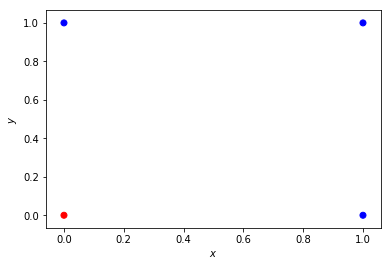

In [67]:
inputs = np.array([[0,0],[0,1],[1,0],[1,1]])
targets = np.array([[0],[1],[1],[1]])
colors = []
for i in range(len(targets)):
    colors.append(['red','blue'][targets[i][0]])
plt.scatter(inputs[:,0],inputs[:,1],color=colors)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Now we use the `pcn` class and instantiate it with the `inputs` and `targets` above. We call `p` an instance of the class `pcn`. In this course we will not dwell on the object oriented aspects of python, so do not worry if you do not fully understand this. However, as you will see below, when we use tensorflow, we have a similar structure: we create an instance of a tensorflow class `model`.

The function definition is `pcntrain(self,inputs,targets,eta,nIterations)`. Do not worry about the `self` part. We call the function as `pcntrain(inputs,targets,0.25,6)`. Hence, the first two arguments of the function are our `inputs` and `targets` tensors. 

The result is that `p` is now associated with our tensors `inputs` and `targets`. Now we can use the function ("method") `pcntrain` to train the network. After each iteration, the algorithm prints some information. Looking at `pcntrain` above, we can see that the information that is printed is:

```
print("Iteration: ", n)
print(self.weights)
print("Final outputs are:")
print(activations)
```

So first we see the number of the iteration (and python starts counting at 0). Then we see three numbers that correspond to the weights. The weights determine the line in the figure above. In particular, if we write the weights tensor as $w = (w_0,w_1,w_2)$, then a line in the figure is given by $w_0 x + w_1 y =w_2$. Equivalently, we can write this as:

\begin{equation}
y = (w_2-w_0 x)/w_1
\end{equation}

Next, we see the final outputs (targets): this is the "prediction" of the algorithm for the vector `targets`. Recall that `targets` is of the form [0,1,1,1]. Hence, after the first iteration, we incorrectly label the first point as 1 while it should be 0. Hence, the algorithm continues and generates different (and ultimately better) predictions.


In [69]:
p = pcn(inputs,targets)
p.pcntrain(inputs,targets,0.25,6)

Iteration:  0
[[ 0.2699222 ]
 [ 0.03411017]
 [-0.22866394]]
Final outputs are:
[[1]
 [1]
 [1]
 [1]]
Iteration:  1
[[0.2699222 ]
 [0.03411017]
 [0.02133606]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]
Iteration:  2
[[0.2699222 ]
 [0.03411017]
 [0.02133606]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]
Iteration:  3
[[0.2699222 ]
 [0.03411017]
 [0.02133606]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]
Iteration:  4
[[0.2699222 ]
 [0.03411017]
 [0.02133606]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]
Iteration:  5
[[0.2699222 ]
 [0.03411017]
 [0.02133606]]
Final outputs are:
[[0]
 [1]
 [1]
 [1]]


The final weights $w$ are now equal to:

In [70]:
p.weights

array([[0.2699222 ],
       [0.03411017],
       [0.02133606]])

We can now plot the line $y=(w_2-w_0 x)/w_1$. Indeed, as you can see, the line sepates the red point (below the line) from the blue points (above the line). If we give the algorithm a point above the line, it will predict "blue", if we give it a point below the line it will predict "red". 

Because we only have 4 points here, this is arbitrary for points close to the line: we can shift the line, still separate the points, but get different predictions for points close to the line.

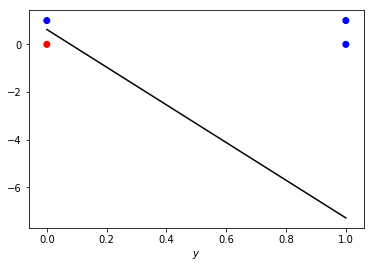

In [71]:
x0 = 0
x1 = 1
y0 = (p.weights[2]-p.weights[0]*x0)/p.weights[1]
y1 = (p.weights[2]-p.weights[0]*x1)/p.weights[1]
plt.scatter(inputs[:,0],inputs[:,1],color=colors)
plt.plot([x0,x1],[y0,y1],'k') #we only need to give two points to plot a line
plt.xlabel('$x$')
plt.xlabel('$y$')
plt.show()

We can see from the graph and check with the function `pcnfwd` below what the predicted labels will be for the points (0.5,0.5) and (0.5,-0.5). The `-1` is needed for the "constant" $w_2$.

In [72]:
p.pcnfwd([[0.5,0.5,-1],[0.5,-0.5,-1]])

array([[1],
       [1]])

To get a "graphical" intuition what a neural network does, see this [website](https://playground.tensorflow.org) and play around with the dataset that you want to use, the number of hidden layers, number of neurons per hidden layer and the features that you want to use.

E.g. choose the dataset where the orange points "circle" the blue points. Use only 1 hidden layer (linear model) and 2 neurons in this layer. Then you cannot perfectly seperate the points. Play around with the options to see how you can separate the points.


## Multi-layer perceptron

With more than one layer, we get into deep learning. This is what "deep" in deep learning refers to: more than one layer.

We use [this mlp code](http://homepages.ecs.vuw.ac.nz/~marslast/Code/Ch4/mlp.py) from Chapter 4 of Machine Learning: An Algorithmic Perspective.

In [74]:

# Code from Chapter 4 of Machine Learning: An Algorithmic Perspective (2nd Edition)
# by Stephen Marsland (http://stephenmonika.net)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008, 2014

import numpy as np

class mlp:
    """ A Multi-Layer Perceptron"""
    
    def __init__(self,inputs,targets,nhidden,beta=1,momentum=0.9,outtype='logistic'):
        """ Constructor """
        # Set up network size
        self.nin = np.shape(inputs)[1]
        self.nout = np.shape(targets)[1]
        self.ndata = np.shape(inputs)[0]
        self.nhidden = nhidden

        self.beta = beta
        self.momentum = momentum
        self.outtype = outtype
    
        # Initialise network
        self.weights1 = (np.random.rand(self.nin+1,self.nhidden)-0.5)*2/np.sqrt(self.nin)
        self.weights2 = (np.random.rand(self.nhidden+1,self.nout)-0.5)*2/np.sqrt(self.nhidden)

    def earlystopping(self,inputs,targets,valid,validtargets,eta,niterations=100):
    
        valid = np.concatenate((valid,-np.ones((np.shape(valid)[0],1))),axis=1)
        
        old_val_error1 = 100002
        old_val_error2 = 100001
        new_val_error = 100000
        
        count = 0
        while (((old_val_error1 - new_val_error) > 0.001) or ((old_val_error2 - old_val_error1)>0.001)):
            count+=1
            print(count)
            self.mlptrain(inputs,targets,eta,niterations)
            old_val_error2 = old_val_error1
            old_val_error1 = new_val_error
            validout = self.mlpfwd(valid)
            new_val_error = 0.5*np.sum((validtargets-validout)**2)
            
        print("Stopped", new_val_error,old_val_error1, old_val_error2)
        return new_val_error
    	
    def mlptrain(self,inputs,targets,eta,niterations):
        """ Train the thing """    
        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((self.ndata,1))),axis=1)
        change = range(self.ndata)
    
        updatew1 = np.zeros((np.shape(self.weights1)))
        updatew2 = np.zeros((np.shape(self.weights2)))
            
        for n in range(niterations):
    
            self.outputs = self.mlpfwd(inputs)

            error = 0.5*np.sum((self.outputs-targets)**2)
            if (np.mod(n,100)==0):
                print("Iteration: ",n, " Error: ",error)

            # Different types of output neurons
            if self.outtype == 'linear':
            	deltao = (self.outputs-targets)/self.ndata
            elif self.outtype == 'logistic':
            	deltao = self.beta*(self.outputs-targets)*self.outputs*(1.0-self.outputs)
            elif self.outtype == 'softmax':
                deltao = (self.outputs-targets)*(self.outputs*(-self.outputs)+self.outputs)/self.ndata 
            else:
            	print("error")
            
            deltah = self.hidden*self.beta*(1.0-self.hidden)*(np.dot(deltao,np.transpose(self.weights2)))
                      
            updatew1 = eta*(np.dot(np.transpose(inputs),deltah[:,:-1])) + self.momentum*updatew1
            updatew2 = eta*(np.dot(np.transpose(self.hidden),deltao)) + self.momentum*updatew2
            self.weights1 -= updatew1
            self.weights2 -= updatew2
                
            # Randomise order of inputs (not necessary for matrix-based calculation)
            #np.random.shuffle(change)
            #inputs = inputs[change,:]
            #targets = targets[change,:]
            
    def mlpfwd(self,inputs):
        """ Run the network forward """

        self.hidden = np.dot(inputs,self.weights1);
        self.hidden = 1.0/(1.0+np.exp(-self.beta*self.hidden))
        self.hidden = np.concatenate((self.hidden,-np.ones((np.shape(inputs)[0],1))),axis=1)

        outputs = np.dot(self.hidden,self.weights2);

        # Different types of output neurons
        if self.outtype == 'linear':
        	return outputs
        elif self.outtype == 'logistic':
            return 1.0/(1.0+np.exp(-self.beta*outputs))
        elif self.outtype == 'softmax':
            normalisers = np.sum(np.exp(outputs),axis=1)*np.ones((1,np.shape(outputs)[0]))
            return np.transpose(np.transpose(np.exp(outputs))/normalisers)
        else:
            print("error")

    def confmat(self,inputs,targets):
        """Confusion matrix"""

        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((np.shape(inputs)[0],1))),axis=1)
        outputs = self.mlpfwd(inputs)
        
        nclasses = np.shape(targets)[1]

        if nclasses==1:
            nclasses = 2
            outputs = np.where(outputs>0.5,1,0)
        else:
            # 1-of-N encoding
            outputs = np.argmax(outputs,1)
            targets = np.argmax(targets,1)

        cm = np.zeros((nclasses,nclasses))
        for i in range(nclasses):
            for j in range(nclasses):
                cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

        print("Confusion matrix is:")
        print(cm)
        print("Percentage Correct: ",np.trace(cm)/np.sum(cm)*100)

This code is more elaborate than the perceptron above. It also introduces new concepts like the confusion matrix. We will go over these below. 

Below we use the famous [iris dataset](http://archive.ics.uci.edu/ml/datasets/Iris). Admittedly, flowers are not directly linked to economics, but this is one of the classic datasets in classification. You cannot claim to have done "datascience" without having looked at the iris dataset.

We will first download it from the website, just to learn the relevant steps here. We will work with it in numpy. In fact, the data is so famous that it is included in the tensorflow library, but later you may want to analyze data that is not included in any library. Hence, we need to learn the download steps as well.

When you look at the downloaded data (in an editor), you will notice that it actually includes the names as strings. For us it is easier to work with numerical labels 0,1,2. Hence, we use the function `preprocessIris`. This function takes two arguments: the input file with the data that we downloaded and the output file where the target-labels are replaced by 0,1,2.

If you run this notebook for the first time, un-comment the line `preprocessIris('iris.data','iris_proc.data')` (that is, remove the hashtag "#" at the beginning of the line), where `iris.data` is the name of the file that you downloaded and `iris_proc.data` is the name of the file with labels 0,1,2. Once the file `iris_proc.data` is created, there is no need to run this python command again.

In [ ]:
# Code from Chapter 4 of Machine Learning: An Algorithmic Perspective (2nd Edition)
# by Stephen Marsland (http://stephenmonika.net)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008, 2014

# The iris classification example

def preprocessIris(infile,outfile):

    stext1 = 'Iris-setosa'
    stext2 = 'Iris-versicolor'
    stext3 = 'Iris-virginica'
    rtext1 = '0'
    rtext2 = '1'
    rtext3 = '2'

    fid = open(infile,"r")
    oid = open(outfile,"w")

    for s in fid:
        if s.find(stext1)>-1:
            oid.write(s.replace(stext1, rtext1))
        elif s.find(stext2)>-1:
            oid.write(s.replace(stext2, rtext2))
        elif s.find(stext3)>-1:
            oid.write(s.replace(stext3, rtext3))
    fid.close()
    oid.close()

## Preprocessor to remove the test (only needed once)
# preprocessIris('iris.data','iris_proc.data')

iris = np.loadtxt('./data/iris_proc.data',delimiter=',')

# we normalize the data (the features, not the labels):
iris[:,:4] = iris[:,:4]-iris[:,:4].mean(axis=0)
imax = np.concatenate((iris.max(axis=0)*np.ones((1,5)),np.abs(iris.min(axis=0)*np.ones((1,5)))),axis=0).max(axis=0)
iris[:,:4] = iris[:,:4]/imax[:4]
print(iris[0:5,:])



# instead of using labels 0,1,2; we use labels like [1,0,0], [0,1,0], [0,0,1]; this is called one-hot encoding
# algorithm that you use determines what the labels should look like
# one-hot encoding is often used when analyzing text-data
target = np.zeros((np.shape(iris)[0],3));
indices = np.where(iris[:,4]==0) 
target[indices,0] = 1
indices = np.where(iris[:,4]==1)
target[indices,1] = 1
indices = np.where(iris[:,4]==2)
target[indices,2] = 1

# Randomly order the data
order = np.arange(np.shape(iris)[0])
np.random.shuffle(order)
iris = iris[order,:]
target = target[order,:]

# Split into training, validation, and test sets
train = iris[::2,0:4]
traint = target[::2]
valid = iris[1::4,0:4]
validt = target[1::4]
test = iris[3::4,0:4]
testt = target[3::4]

Uncomment and evaluate the following cell if you want to get an idea what the data look like.

In [84]:
#print(iris)
#print(train.max(axis=0), train.min(axis=0))

Next we train the network:

In [85]:
# Train the network
#import mlp
net = mlp(train,traint,5,outtype='logistic')
net.earlystopping(train,traint,valid,validt,0.1)
net.confmat(test,testt)

1
Iteration:  0  Error:  25.664241064005743
2
Iteration:  0  Error:  0.11515693234907126
3
Iteration:  0  Error:  0.0503108315145214
Stopped 3.3169010700213746 3.250089890472476 3.1219788840585454
Confusion matrix is:
[[10.  0.  0.]
 [ 0. 14.  0.]
 [ 0.  0. 13.]]
Percentage Correct:  100.0


As the choice of train, evaluate and test data is random, the results can differ here.

The idea of the confusion matrix is as follows:
* the rows are the true labels, the columns are the predicted labels;
* if all non-diagonal entries equal 0, the model gives a perfect prediction;
* if the element on the 3 rd row and 1st column is positive: some observations that actually have the 3rd label are incorrectly predicted to have the 1st label.

When there are a lot of labels, looking at the confusion matrix is no longer helpful. A number of summary measures have been defined for such cases, like accuracy, sensitivity, precision etc.

## Intermezzo: Tensorflow regression

Before we do classification in tensorflow, let's quickly look at a simple regression example. In this way you can get used to the notation and syntax of tensorflow, while looking at something (regression) that you already fully understand (we hope...).

This example is copied from [this SciPy 2019 Tutorial](https://www.youtube.com/watch?v=E0-mp5UlWzo) starting at 14:30.



A minimal example of linear regression in TensorFlow 2.0, written from scratch without using any built-in layers, optimizers, or loss functions. We'll create a few points on a scatter plot, then find the best fit line using the equation `y = m * x + b`.

We create our own dataset. The function `make_noisy_data` has default values for its parameters. Hence, we can call it without parameters. But we can also specify a different value, like $m = 2.0$. It is a good exercise to play around with these parameter values.

In [86]:
def make_noisy_data(m=0.1, b=0.3, n=100):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.01)
    y = m * x + b + noise
    return x, y

x_train, y_train = make_noisy_data()






**Question** Plot the training data.

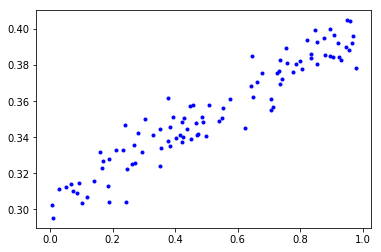

In [87]:
plt.plot(x_train, y_train, 'b.')

Next we define the tensorflow variables `m,b` and give them a starting value. Tensorflow now knows that `m,b` are variables that will be varied (trained) later on.

In [88]:
m = tf.Variable(0.)
b = tf.Variable(0.)

We can look at the variables, but they are not "easy to look at" as they contain more information than just the value. If we are only interested in the value, we can use the `numpy()` method on the variable.

In [89]:
print(m)
print(m.numpy())

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
0.0


We define a function that predicts `y` for given `x`. Note that tf "knows" that `m,b` are variables because of the way we defined these variables above. Hence, they are not explicitly mentioned in the function definition as variables.

In [90]:
def predict(x):
    y = m * x + b
    return y

In [91]:
def squared_error(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

Our error measure is sum of squared differences between `y_pred` and `y_true`.

To see what `reduce_mean` does, consider the following example. If the tensor `vector` has more than 1 dimension, you can specify the axis along which the reduction needs to take place.

In [92]:
vector = tf.constant([[1., 2., 3., 4.]])
print(tf.reduce_mean(vector).numpy())

2.5


**Question** Before we train the model, i.e. with our starting values for `m,b`, calculate the `squared error` that we have.

In [93]:
loss = squared_error(predict(x_train), y_train)
loss.numpy()

0.12608078

Machine learning is all about reducing the loss (incorrect predictions). Most algorithms calculate the derivative of the loss function w.r.t. the parameters of the model. Then change the parameters in such a way that the loss is indeed reduced. We program a very simple gradient descent algorithm.

We use gradient descent to gradually improve our guess for `m` and `b`. At each step, we'll nudge them a little bit in the right direction to reduce the loss.

In [94]:
learning_rate = 0.05
steps = 200

for i in range(steps):
  
    with tf.GradientTape() as tape:
        predictions = predict(x_train)
        loss = squared_error(predictions, y_train)
    
    gradients = tape.gradient(loss, [m, b])
  
    m.assign_sub(gradients[0] * learning_rate)
    b.assign_sub(gradients[1] * learning_rate)
  
    if i % 20 == 0:    
        print("Step %d, Loss %f" % (i, loss.numpy()))

Step 0, Loss 0.126081
Step 20, Loss 0.000784
Step 40, Loss 0.000239
Step 60, Loss 0.000200
Step 80, Loss 0.000172
Step 100, Loss 0.000150
Step 120, Loss 0.000133
Step 140, Loss 0.000120
Step 160, Loss 0.000110
Step 180, Loss 0.000102


Two things in the code above are new: `GradientTape` and `assign_sub`. We will discuss these briefly.

More information on GradientTape can be found [here](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape) where you select API: r2.0 (beta), to get the right version.

As a simple example to get an idea of what it does, we work with the function $z^2$. `gradient` calculates the derivative (it does so analytically) and fills in the value, in this case 3.0. Hence, the derivative equals $2*z = 6.0$ at $z=3.0$.

In [27]:
z = tf.Variable(3.0)
def my_function():
    return z**2

with tf.GradientTape() as tape:
    value = my_function()
tape.gradient(value, [z])



[<tf.Tensor: id=8424, shape=(), dtype=float32, numpy=6.0>]

**Question** Define the function $z_1^2+z_2^2-4z_1 z_2$ and calculate its derivatives w.r.t. $z_1,z_2$ in the point $z_1 = 1.0, z_2 = -2.0$.

In [96]:
z1 = tf.Variable(1.0)
z2 = tf.Variable(-2.0)
def my_function():
    return z1**2+z2**2-4*z1*z2

with tf.GradientTape() as tape:
    value = my_function()
tape.gradient(value, [z1,z2])


[<tf.Tensor: id=1008241, shape=(), dtype=float32, numpy=10.0>,
 <tf.Tensor: id=1008242, shape=(), dtype=float32, numpy=-8.0>]

`assign_sub` subtracts the value from the variable:

In [97]:
z = tf.Variable(3.0)
z.assign_sub(1.0)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2.0>

As you know from the Taylor expansion of $f(x)$ around $x=a$, we can write:

$$
f(x) = f(a) + f'(a)(x-a)
$$

Hence, if you try to minimize the function $f$, you should "walk" in the direction where $f$ is falling in $x$. The size of your step is determined by `learning_rate`. Big steps imply that you walk fast in the right direction, but you may jump over the minimum. With a small step size you are less likely to jump over the minimum, but it may take longer to get there.

If $f'(x) >0$ and we want to minimize $f$, we should reduce $x$ to get closer to the minimum. Hence, our algorithm would do: $x_1 = x_0 - f'(a)*\varepsilon$ where $\varepsilon > 0$ is the learning rate.

This is exactly what the code `m.assign_sub(gradients[0] * learning_rate)` does.

Note that there are some issues here with local and global minima that we will not worry about.

Back to our regression problem, the values for the parameters that we have found are:

In [98]:
print ("m: %f, b: %f" % (m.numpy(), b.numpy()))

m: 0.110885, b: 0.295510


**Question** Plot the regression line together with the data in one figure.

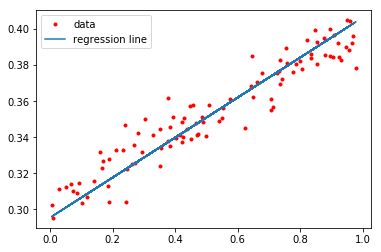

In [100]:
plt.plot(x_train, y_train, 'r.', label = 'data')
plt.plot(x_train, predict(x_train),label = 'regression line')
plt.legend()

## Tensor classification

We first use the iris dataset to see how it works. However, this dataset is rather small, hence we move on to a bigger dataset below.

In [23]:
iris_features = iris[:,0:4]
iris_target = iris[:,4]

In [24]:
model = keras.Sequential([
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.fit(iris_features, iris_target, epochs=10)

Epoch 1/10
150/150 [==============================] - 0s 614us/sample - loss: 1.0717 - accuracy: 0.3733
Epoch 2/10
150/150 [==============================] - 0s 42us/sample - loss: 1.0528 - accuracy: 0.4533
Epoch 3/10
150/150 [==============================] - 0s 40us/sample - loss: 1.0327 - accuracy: 0.5533
Epoch 4/10
150/150 [==============================] - 0s 42us/sample - loss: 1.0140 - accuracy: 0.6467
Epoch 5/10
150/150 [==============================] - 0s 40us/sample - loss: 0.9936 - accuracy: 0.7467
Epoch 6/10
150/150 [==============================] - 0s 38us/sample - loss: 0.9732 - accuracy: 0.7733
Epoch 7/10
150/150 [==============================] - 0s 40us/sample - loss: 0.9515 - accuracy: 0.7867
Epoch 8/10
150/150 [==============================] - 0s 39us/sample - loss: 0.9271 - accuracy: 0.8067
Epoch 9/10
150/150 [==============================] - 0s 41us/sample - loss: 0.9026 - accuracy: 0.8267
Epoch 10/10
150/150 [==============================] - 0s 50us/sample - 

## Back to our first neural network

After having seen some tensorflow syntax in a simple regression example, let's look at a classification problem again.

As the iris dataset is rather small, we cannot meaningfully split it up further in a train and test set. To do a proper analysis, we go back to our first neutral network that we specified above using the mnist data set on classifying handwritten numbers.

We borrow parts of the analysis from [here.](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/keras/basic_classification.ipynb)

In [101]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

**Question** Determine the shape of `train_images`.

In [102]:
train_images.shape

(60000, 28, 28)

To get an idea of how these numbers are actually coded, we plot them in the following figure.

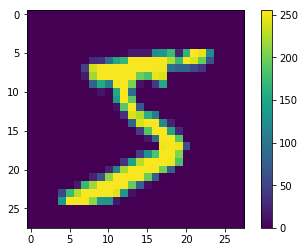

In [103]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

It is generally a good idea to standardize your features such that they are between 0 and 1. Hence we divide by 255, because

In [107]:
print(train_images[0].min())
print(train_images[0].max())

0
255


In [108]:
train_images = train_images/255.0

test_images = test_images/255.0

We can plot some of our data and show the label for each figure below it.

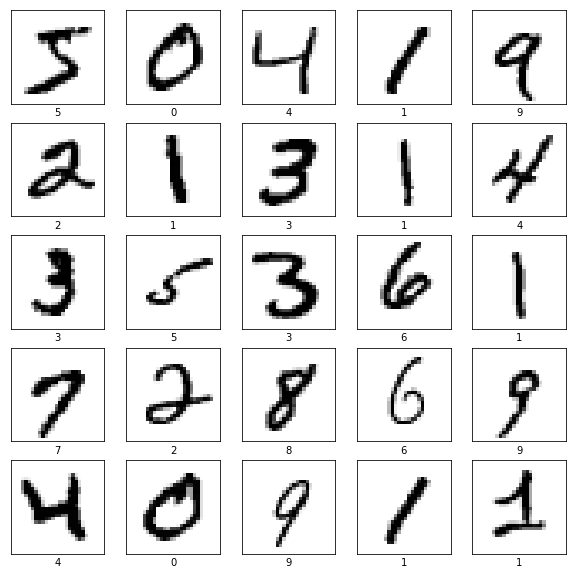

In [109]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

We define the same model as we did before, but give some more explanation.

In [140]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



We use `keras` to define our deep neural network. The first line of our model, `keras.layers.Flatten`, is not a layer but specifies that we flatten our two dimensional figures into one dimensional vectors. Depending on the algorithm that you use, this step may not be necessary.

After "flattening" our input vector is $28*28 = 784$ entries long. Our first layer has 128 nodes. The layer is "dense" in the sense that each of the 784 input nodes is connected to all the 128 nodes in the first layer.

The activation function of this first layer is `relu`, meaning $\max(0,x)$. So to calculate the output of this layer, we do the following: $output = W \times input + b$ where the matrix $W$ and vector $b$ are the parameter values that we want to determine. Then the output of the first layer is $\max(0,ouput)$ for each node. If $output \leq 0$, the node is not activated.

Then we map these 128 nodes into out final layer which is a probability distribution (`softmax`) over the 10 potential labels. The label with the highest probability is our predicted label.

Then we compile our model by specifying the optimizer that we want to use; `adam` is usually a good choice. We specify the loss function that we want to minimize and we can specify other variables that we want to keep track off.

To see what the options are for `model.compile`, run `model.compile?` in a cell. In the documentation, there is, for instance, a reference to `tf.keras.optimizers`. The simplest way to access this, is to use the tensorflow website (with the correct API) and look at: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers

We estimate ('fit') the model on the train set. Here we specify 10 epochs.

To estimate the model we usually do not want to use all the data at once as that would slow down the algorithm. Hence we take a "minibatch" (sample; the size of which can be set by `batch_size`) from our data and estimate the model on this sample. Then we take another sample etc.

In this way, a given observation can be used in a number of samples when estimating the model. The parameter `epochs` specifies how often a given datapoint is used in a sample to estimate the model.

In [141]:
model.fit(train_images, train_labels, epochs=10)


Epoch 1/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2588 - accuracy: 0.9266
Epoch 2/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1125 - accuracy: 0.9674
Epoch 3/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0769 - accuracy: 0.9765
Epoch 4/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0580 - accuracy: 0.9821
Epoch 5/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0447 - accuracy: 0.9863
Epoch 6/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0355 - accuracy: 0.9891
Epoch 7/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0291 - accuracy: 0.9906
Epoch 8/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.0221 - accuracy: 0.9934
Epoch 9/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0187 - accuracy: 0.9946
Epoch 10/10
60000/60000 [============

As we worry about overfitting, the fit on the training set is not very informative (unless this fit is already very bad). Hence, we use our fitted model and then evaluate it using the test data. That is, given the test_images, we predict (using the fitted model) a label; we then compare this label with the true `test_labels`.

The accuracy on the test set is (as one would expect) lower than on the train set. Hence, there is some overfitting of the model on the training set. Some features of the train data are picked up by the model that do not generalize to the test data.

Below we will use the prediction on the test set to determine the optimal number of epochs with an eye on overfitting.

In [142]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('\nTest accuracy:', test_acc)


10000/10000 [==============================] - 0s 28us/sample - loss: 0.0857 - accuracy: 0.9771

Test accuracy: 0.9771


We can generate predictions for the test set and consider explicitly the prediction for the first image (index 0). This prediction gives the probability for each possible label 0-9.

In [143]:
predictions = model.predict(test_images)


**Question** What is the prediction for the first image?

In [144]:
predictions[0]

array([8.2473589e-10, 1.2718541e-10, 1.9067457e-07, 4.3082058e-05,
       6.1509561e-14, 4.6733628e-10, 2.9344173e-17, 9.9995661e-01,
       1.5265439e-08, 8.2346034e-08], dtype=float32)

**Question** If you had to make a "point prediction" which label (number) would you predict for the first image? Compare this to the true label of the first image in the test set.

In [145]:
print(np.argmax(predictions[0]))
print(test_labels[0])


7
7


**Question** As a final check, plot the first image.

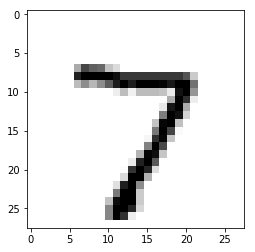

In [146]:
plt.imshow(test_images[0],cmap=plt.cm.binary)
plt.show()

The following code "automizes" plotting an image together with its true and predicted label. Then we can plot a number of images, together with their predictions. If the prediction is correct, the figure is in blue, else in red.

As the accuracy is quite high, you may not see any red images.

In [147]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

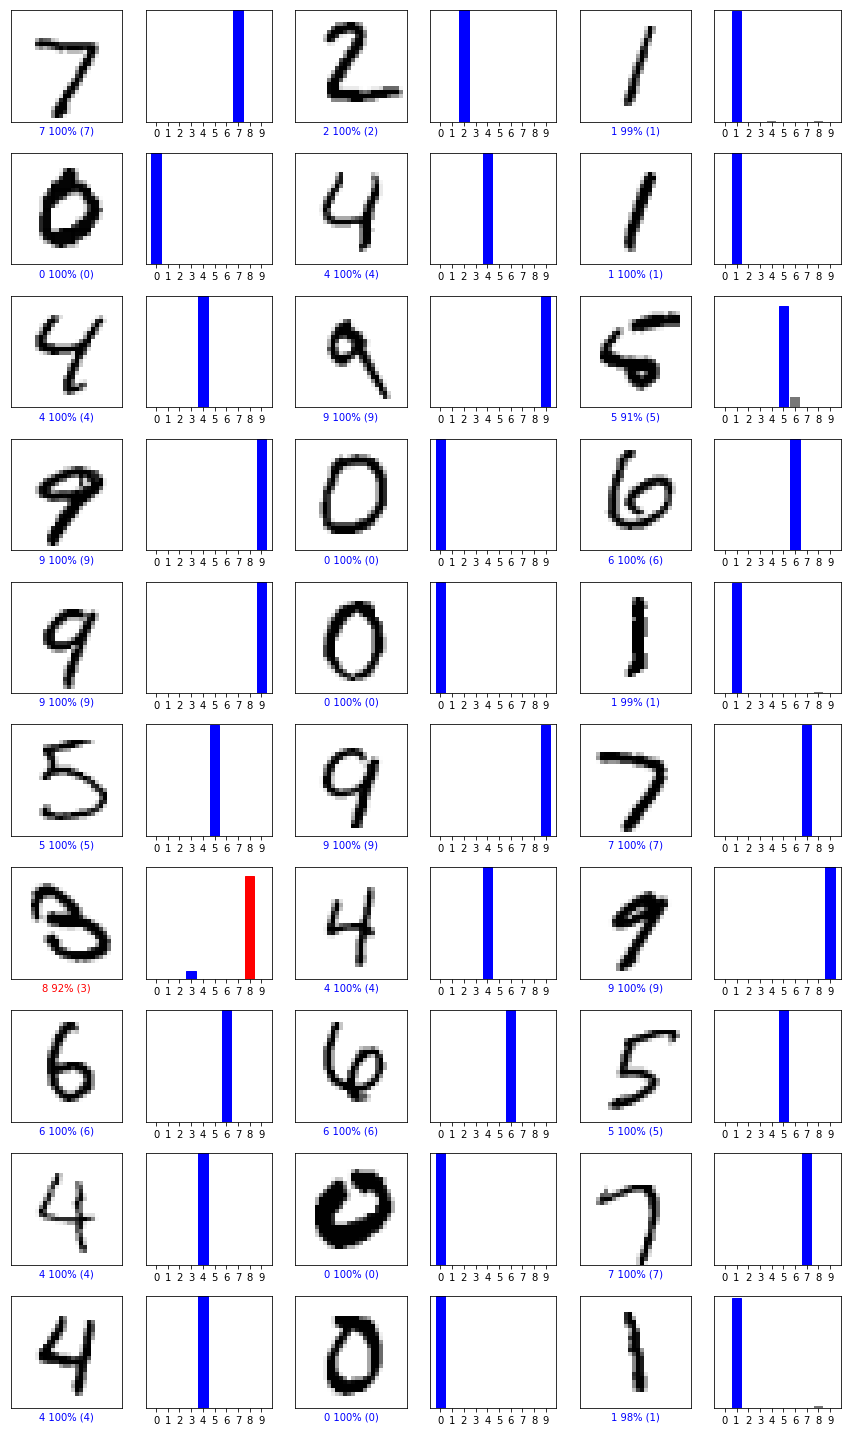

In [148]:
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Finally, we consider the problem of how to choose the number of epochs to reduce overfitting. That is, for each value of `epochs` we save the loss and accuracy in `history`. Then we plot loss and accuracy against `epochs` for the train data and the validation/test data.



In [149]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_images,
                    train_labels,
                    epochs=50,
                    batch_size=512,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.5883 - accuracy: 0.8462 - val_loss: 0.2814 - val_accuracy: 0.9239
Epoch 2/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.2542 - accuracy: 0.9297 - val_loss: 0.2129 - val_accuracy: 0.9402
Epoch 3/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.1974 - accuracy: 0.9445 - val_loss: 0.1756 - val_accuracy: 0.9501
Epoch 4/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.1621 - accuracy: 0.9542 - val_loss: 0.1505 - val_accuracy: 0.9551
Epoch 5/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.1378 - accuracy: 0.9611 - val_loss: 0.1362 - val_accuracy: 0.9612
Epoch 6/50
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1193 - accuracy: 0.9655 - val_loss: 0.1199 - val_accuracy: 0.9649
Epoch 7/50
60000/60000 [==============================] 

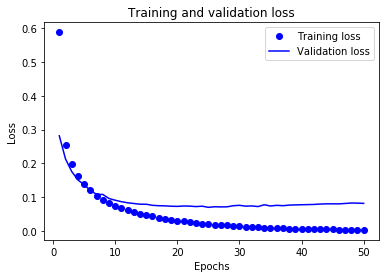

In [150]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

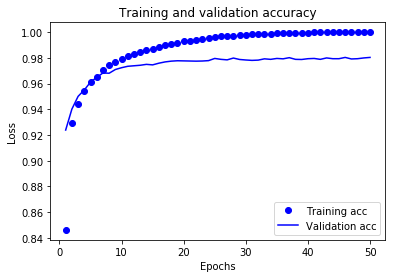

In [151]:
#plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see, loss decreases (and accuracy increases) with the number of epochs on the train data. However, this is not true for the test data.

For more than, say, 10 epochs, the loss on the test data hardly falls. Hence, the "gain" on the train data of having more than 10 epochs is due to overfitting. 

# Treatment effects

Machine learning is about predicting outcomes. When the prediction is accurate (out-of-sample) we are happy, almost no matter what the model looks like. When we are trying to predict an outcome, we do not worry about the fact that one of the variables that we use, can be endogenous. As long as the variable is available when we need to predict, it is fine to use it.

This is different when we are interested in policy advice, which we often are in economics. [This recent paper](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.31.2.87) discusses how machine learning can be used in economics. It gives examples of economic problems where prediction is, in fact, important. One such example in econometrics is instrumental variables (IV): the first stage in IV is basically generating a prediction. See [this paper](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.28.2.29) on how machine learning can be used to select instruments. To facilitate reading these papers, this section gives a statistical hacker's introduction to IV and estimating treatment effects.



## IV

To illustrate what instrumental variables are, we consider the IV example in [Richard McElreath's lecture 18
](https://www.youtube.com/watch?v=e5cgiAGBKzI) (starting around 28:00) which is based on Angrist and Krueger (1991).

You will not be surprised to hear that an individual's education (`e`) affects her/his wage (`w`). That may well be the reason that you are at university. We want to know how strong this effect is. That is, if you do a year more of education, with how much does your wage increase?

A first (naive) way to analyze this is to regress years of education on wage using an individual level dataset. The problem here is a fork (see our discussion of causality above): personal motivation is likely to affect both educational achievement and wage. If someone has a high level of motivation to succeed in things, they will tend to have a high educational achievement (they are unlikely to drop out of school) and a high wage (they will be successful at their job as well). Hence, such a naive regression is likely to over-estimate the effect of education on wage.

What we need is an exogenous variation in educational achievement; hence a variation that is not affected by how motivated a pupil is. In a number of countries the time you spend in school is determined by your date of birth. E.g. in the Netherlands, you go to primary school in the month where you turn 4. In other countries you can drop out of school in the month where you become 16. Hence, depending on your birth date, you spend a couple of months more (or less) in school. We assume that your month of birth is not correlated with how motivated you are when it comes to school and work.

We simulate data taking this effect into account. Because we simulate the data, you can see exactly what is going on. We know the data generating process, the question is: which estimation technique is capable of uncovering the correct underlying parameters.

The variable `q` captures this exogenous variation in school attendance due to birth month.

We generate a dataframe `df` containing the variables `q, e, w`. 

**Question** Interpret the python code that generates the data. In particular, what is the role of `u` and what does `beta_ew = 0` mean?

In [152]:
N_observations=200
alpha_w = 1.
beta_ew = 0.
alpha_e = 1.
beta_qe = 2.
q = tf.random.uniform([N_observations])
u = tf.random.normal([N_observations])
e = alpha_e + beta_qe*q + u + tf.random.normal([N_observations])
w = alpha_w + beta_ew*e + u + tf.random.normal([N_observations])
df = pd.DataFrame({'q':q,'e':e,'w':w})

**Question** Use `smf.ols` to run the "naive" regression of `e` on `w`. What is the effect of education on wage? Discuss this effect.

In [153]:
results = smf.ols('w ~ e', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     51.39
Date:                Wed, 14 Aug 2019   Prob (F-statistic):           1.47e-11
Time:                        19:15:22   Log-Likelihood:                -319.43
No. Observations:                 200   AIC:                             642.9
Df Residuals:                     198   BIC:                             649.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2117      0.138      1.531      0.1

Now from `linearmodels.iv` we use `IV2SLS.from_formula` to run the IV, where `q` instruments for `e`.

In [154]:

mod = IV2SLS.from_formula('w ~ 1 + [e ~ q]', df)

iv_res = mod.fit()
iv_res

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      w   R-squared:                     -0.3427
Estimator:                    IV-2SLS   Adj. R-squared:                -0.3495
No. Observations:                 200   F-statistic:                    1.2370
Date:                Wed, Aug 14 2019   P-value (F-stat)                0.2660
Time:                        19:20:24   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.4875     0.4579     3.2482     0.0012      0.5899      2.3850
e             -0.2540     0.2284    -1.1122     0.2660     -0.7015      0.1936
==============================================================================

Endogenous: e
Instruments: q
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7fd6193544a8

**Question** Discuss the effect of education on wage in this regression.

The effect of `e` on `w` is no longer significant. This (correctly) suggests that we cannot reject the hypothesis that this effect equals 0 (which indeed it does).

In [155]:
iv_res.first_stage

,e
R-squared,0.1172
Partial R-squared,0.1172
Shea's R-squared,0.1172
Partial F-statistic,24.929
P-value (Partial F-stat),5.947e-07
Partial F-stat Distn,chi2(1)
==========================,===========
Intercept,1.0314
,(5.2310)
q,1.7829


**Question** Interpret the effect of `q` on `e` in the first stage regression. Is this correct?

The effect is positive and significant. In fact, the true effect equals `beta_qe = 2.` which is close enough to 1.78.

## Heterogenous treatment effects

One of the complications when using IV to find causal effects is that treatment effects can differ between subgroups and that these subgroups react differently to the treatment/instrument. Our discussion here is based on Chapter 4 of Angrist and Pischke (2009).

We will consider this in the context of unemployed who are offered a training program. To understand the effects, we will again generate our own data such that we know exactly what all the relevant effects are. The question is then, how do we get these effects from the data.

As before, the learning goals of this section are two fold: (i) learn how to program your own data generating process in python and (ii) understand the statistical issue under considerarion: heterogenous treatment effects.

The government introduces a training program for unemployed. The treatment variable $D_i$ denotes whether (1) or not (0) individual $i$ received training. The instrument $Z_i$ that we use is whether (1) or not (0) $i$ is invited to join the training. 

We have three groups of unemployed:

* compliers join the training if and only if they are invited to do so: $D_i = 1 (0)$ iff $Z_i = 1 (0)$;
* always-takers join the training whether or not they are invited to do so: $D_i =1$ irrespective of $Z_i$;
* never-takers never join the training: $D_i = 0$ irrespective of $Z_i$.

Note that in this training context, the always-takers are a bit "odd": how can you join a training program where you are not supposed to be. The never-takers make more sense in this context: some people may not attend the training even though they were invited to do so. We will not worry about this; the point is that we can conceptually distinguish these groups.

We are interested in the effect of the training program on earnings. We denote by $\beta$ the expected earnings without training. The expected earnings with training is denoted by $\beta+\tau$. Hence, $\tau$ denotes the treatment effects.

Let $j \in \{c,a,n \}$ denote whether an individual is a complier, always-taker or never-taker. We assume that $\beta_j$ and $\tau_j$ vary with $j$.

In particular we assume that the earnings effect for someone in group $j$ is drawn from a normal distribution with mean $\mu = \beta_j$ and standard deviation $\sigma =1$ in case of no training and the effect of training is drawn from a normal distribution with mean $\mu = \tau_j$ and standard deviation $\sigma =1$.

Below we will consider different configurations for $\beta_j, \tau_j$ and see how they affect the estimated effects.

**Exercise** Read the code below and explain what it does. E.g. can you explain how earnings depend on whether someone was invited for the training program?

In [156]:
def accept_complier(invited):
    return invited

def accept_always(invited):
    return np.ones_like(invited)

def accept_never(invited):
    return np.zeros_like(invited)

N_simulations = 10000
fraction_training = 0.2 # 20% of agents are invited to the training
types = ['complier','always_taker', 'never_taker']
β = {'complier': 1, 'always_taker': 2, 'never_taker': 1}
τ = {'complier': 3, 'always_taker': 4, 'never_taker': 1}
n = {'complier': 0.5, 'always_taker': 0.25, 'never_taker': 0.25}
accept = {'complier': accept_complier, 'always_taker': accept_always, 'never_taker': accept_never}
earnings_without = {}
training_effect = {}
earnings = {}
invited = {}
trained = {}
df = pd.DataFrame()
def data_simulation(β = β, τ=τ, n = n):
    for j in types:
        earnings_without[j] = np.random.normal(loc = β[j], scale = 1.0, size = int(n[j]*N_simulations))
        training_effect[j] = np.random.normal(loc = τ[j], scale = 1.0, size = int(n[j]*N_simulations))
        invited[j] = np.random.binomial(1,fraction_training,size = int(n[j]*N_simulations))
        trained[j] = accept[j](invited[j])
        earnings[j] = earnings_without[j]+ trained[j]*training_effect[j]
    column_invited = np.concatenate([invited[j] for j in types],axis=0)
    column_trained = np.concatenate([trained[j] for j in types],axis=0)
    column_earnings = np.concatenate([earnings[j] for j in types],axis=0)
    df = pd.DataFrame({'invited':column_invited, 'trained':column_trained,'earnings':column_earnings})
    return df
 
df = data_simulation()
df.head()

,invited,trained,earnings
0,0,0,2.340214
1,0,0,0.006753
2,0,0,-0.277973
3,0,0,2.738156
4,1,1,2.643201


We have a dataset now with indicators for who was invited to a training and who attended a training.

We would like to learn the effect of training on earnings.

**Question** Which of the parameters above could we hope to recover? $\tau_c,\tau_a,\tau_n$?

**Question** Hence, if we do some calculations with the data, which number do we want to see?

**Question** Compare the average earnings of people with training with the average earnings of people without training. Is this the number that you expected? Why (not)?

We can only hope to recover $\tau_c$ as we observe `compliers` both with and without training.

We want to see the number $\tau_c = 3$.

We compare the average earnings of people with training with the average earnings of people without training.

In [65]:
np.mean(df[df.trained==1].earnings)-np.mean(df[df.trained==0].earnings)

4.419601275141817

**Exercise** Where does this number come from?


In [157]:
(0.1*4+0.25*6)/0.35-(0.4*1+0.25*1)/0.65

4.428571428571429

**Question** Perhaps we should use the instrument whether someone if invited or not: compare average earnings of people with and without an invitation to the training.

In [158]:
np.mean(df[(df.invited==1)].earnings)-np.mean(df[(df.invited==0)].earnings)

1.4333612450319868

**Question** Does it help if we compare:
* people with training and an invitation to training *with*
* people without training and no invitation to training

In [159]:
np.mean(df[(df.trained==1)&(df.invited==1)].earnings)-np.mean(df[(df.trained==0)&(df.invited==0)].earnings)

3.5704389244549586

Hence, this does not give us $\tau_c = 3$ either.

We have seen now that we have no hope of recovering the relevant training effect in the set-up above. So the question is: when can we recover the relevant parameters? That is, what assumptions are needed?

To see how you can analyze this with the set-up above, let's program two obvious cases where this works.

**Question** Explain for each case *why* it works.

In [160]:
n = {'complier': 1.0, 'always_taker': 0.0, 'never_taker': 0.0}
df_compliers_only = data_simulation(n=n)
np.mean(df_compliers_only[df_compliers_only.trained==1].earnings)-np.mean(df_compliers_only[df_compliers_only.trained==0].earnings)

2.9830066896334713

In [161]:
β = {'complier': 1, 'always_taker': 1, 'never_taker': 1}
τ = {'complier': 3, 'always_taker': 3, 'never_taker': 3}
df_homog = data_simulation(β=β,τ=τ)
np.mean(df_homog[df_homog.trained==1].earnings)-np.mean(df_homog[df_homog.trained==0].earnings)

3.0022015727805695

The first works because there are only compliers and for this group we can simply compare earnings of trained and non-trained people: training-treatment is random and and compliers follow the recommendation made (train or no train).

The second works because each type has the same $\beta, \tau$.

For a less obvious case where we can retrieve relevant parameters, we will use Angrist and Pischke (2009: chapter 4). In particular, we will verify Theorem 4.4.2.

We work with one sided noncompliance. That is, we allow for never-takers but not for always-takers. 

According to Theorem 4.4.2 the effect of treatment on the treated can be found as:

$$
\frac{E(Y_i|Z_i=1)-E(Y_i|Z_i=0)}{Prob(D_i=1|Z_i=1)}
$$

We first create the dataframe.

In [162]:
n = {'complier': 0.5, 'always_taker': 0.0, 'never_taker': 0.5}
df_one_sided = data_simulation(n=n)


**Question** Calculate $Prob(D_i = 1|Z_i =1)$ and denote this `correction_term`.

In [163]:
correction_term = np.sum(df_one_sided[df_one_sided.invited==1].trained)/np.sum(df_one_sided[df_one_sided.invited==1].invited)

**Question** Calculate $\frac{E(Y_i|Z_i=1)-E(Y_i|Z_i=0)}{Prob(D_i=1|Z_i=1)}$.

In [164]:
(np.mean(df_one_sided[df_one_sided.invited==1].earnings)-np.mean(df_one_sided[df_one_sided.invited==0].earnings))/correction_term

2.960547816059347

**Question** Which parameter have we recovered?

This gives us $\tau_c = 3$.

## Probability of treatment

Consider a situation which is simpler than the one above in the sense that there are no always-takers, nor never-takers.

However, now the instrument ("invited") $Z$ causes the probability of training to increase from 0.2 to 0.6. 30% of people get invited.

**Exercise** Copy/paste python code from the analysis above to generate a dataframe using that $Z_i=1$ implies that the probability of treatment increases from 0.2 to 0.6

In [165]:
N_simulations = 10000
types = ['invited','not_invited']
β = 1
τ = 3
n = {'invited': 0.3, 'not_invited': 0.7}
prob_training = {'invited': 0.6, 'not_invited': 0.2}
earnings_without = {}
training_effect = {}
earnings = {}
trained = {}
df = pd.DataFrame()
def data_simulation_prob(β = β, τ=τ, n = n):
    for j in types:
        earnings_without[j] = np.random.normal(loc = β, scale = 1.0, size = int(n[j]*N_simulations))
        training_effect[j] = np.random.normal(loc = τ, scale = 1.0, size = int(n[j]*N_simulations))
        trained[j] = np.random.binomial(1,prob_training[j],size = int(n[j]*N_simulations))
        earnings[j] = earnings_without[j]+ trained[j]*training_effect[j]
    column_invited = np.concatenate([np.ones_like(trained['invited']),np.zeros_like(trained['not_invited'])],axis=0)
    column_trained = np.concatenate([trained[j] for j in types],axis=0)
    column_earnings = np.concatenate([earnings[j] for j in types],axis=0)
    df = pd.DataFrame({'invited':column_invited, 'trained':column_trained,'earnings':column_earnings})
    return df
 
df_prob = data_simulation_prob()
df_prob.head()

,invited,trained,earnings
0,1,0,0.000355
1,1,1,5.610210
2,1,0,0.662399
3,1,1,3.078257
4,1,1,3.106668


**Question** Suppose we can observe whether someone received training or not. Use this to calculate the effect of training on earnings.

In [166]:
(np.mean(df_prob[df_prob.trained==1].earnings)-np.mean(df_prob[df_prob.trained==0].earnings))

2.970262548043806

Suppose we cannot observe whether someone actually did the training or not (e.g. whether or not someone invested effort in the training). We only know ("from a previous study") that explicitly inviting someone for the training ("nudge") increases the probability that they invest training effort from 0.2 to 0.6.

**Question** Use the dataframe above to verify what the effect of the nudge is. Call this the `correction_term`. What value should the correction term have?

In [169]:
correction_term = (np.mean(df_prob[df_prob.invited==1].trained)-np.mean(df_prob[df_prob.invited==0].trained))
correction_term # should equal the effect of the nudge: 0.6 - 0.2 = 0.4

0.4051904761904762

Angrist and Pischke (2009: chapter 4) Theorem 4.4.1 (LATE Theorem; local average treatment effect) claims that (under some assumptions), we can calculate the effect of training on earnings as:

$$
\frac{E(Y_i|Z_i=1)-E(Y_i|Z_i=0)}{E(D_i|Z_i=1)-E(D_i|Z_i=0)}
$$

**Question** Use this expression to calculate the effect of training on earnings.

In [170]:
(np.mean(df_prob[df_prob.invited==1].earnings)-np.mean(df_prob[df_prob.invited==0].earnings))/correction_term

2.884382524298704

Now we are going to use an IV estimation to find the same result. Run the following two regressions.

In [171]:
results_first_stage = smf.ols('trained ~ invited', data=df_prob).fit()
results_second_stage = smf.ols('earnings ~ invited', data=df_prob).fit()

**Question** Use these regressions to calculate the effect of training on earning.

In [172]:
results_second_stage.params[1]/results_first_stage.params[1]

2.8843825242983923